In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow.keras.backend as K 
import gym
import numpy as np
import random as rand

DQN
=======

In [3]:
class Agent(object):
    def __init__(self):
        # 프로그램 동작 설정
        self.env = gym.make("CartPole-v1")
        self.state_size = self.env.observation_space.shape[0] # cartpole이 가진 state 개수
        self.action_size = self.env.action_space.n # cartpole의 agent가 선택할 수 있는 action의 개수

        # model의 설정
        self.node_num = 12 # nn layer에 들어있는 node의 개수
        self.learning_rate = 0.001
        self.epochs_cnt = 5
        self.model = self.build_model()
        
        # 학습 설정
        self.discount_rate = 0.97
        self.penalty = -100 # 막대가 cartpole에서 떨어져 종료되었을 때 받을 음의 보상의 크기
        
        # 반복 설정 영역 
        self.episode_num = 500 # 몇 번의 episode를 반복하여 data를 수집할 것인가

        # data 수집 환경
        self.replay_memory_limit = 2048
        self.replay_size = 32 # mini batch통해 학습할 데이터의 양을 지정
        self.replay_memory = [] # 수집한 cartpole의 실행 정보가 저장

        # 탐험 환경 설정
        self.epsilon = 0.99
        self.epsilon_decay = 0.2
        self.epsilon_min = 0.05

        # training monitoring
        self.moving_avg_size = 20 # moving average size3
        self.reward_list = []
        self.count_list = [] # 각 episode에서 cartpole이 실행된 횟수
        self.moving_avg_list = []

    def build_model(self): # neural net build
        input_states = Input(shape = (1,self.state_size), name = "input_states") # model : state -> q value for each action
        x = (input_states)
        x = Dense(self.node_num, activation = "relu")(x) # hidden layer의 node 개수
        out_actions = Dense(self.action_size, activation = "linear", name = "output")(x) # output layer = q value per actions
        model = tf.keras.models.Model(inputs = [input_states], outputs = [out_actions])
        model.compile(optimizer = Adam(learning_rate = self.learning_rate), loss = "mean_squared_error")
        model.summary()
        return model
    
    def train(self): # train the model
        for episode in range(self.episode_num): # step : cartpole이 한 번 실행되는 것 // episode : cartpole이 처음 실행되어 종료될 때까지의 전 과정
            state,_ = self.env.reset() # cartpole 실행 환경의 초기화
            Q, count, reward_tot = self.take_action_and_append_memory(episode, state) # 경험을 기록

            if count < 500:
                reward_tot = reward_tot - self.penalty
            
            # 하나의 episode 종료 -> 수집된 보상과 실행 횟수 저장
            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list, self.moving_avg_size))

            # replay memory에 저장된 데이터를 replay_size만큼 가져와서 학습
            self.train_mini_batch(Q)

            # training log
            if (episode%10 == 0 ):
                print("episode : {}, moving_avg : {}, rewards_avg : {}".format(episode, self.moving_avg_list[-1],np.mean(self.reward_list)))
        self.save_model()

    def take_action_and_append_memory(self, episode, state):
        reward_tot = 0
        count = 0
        done = False

        epsilon = self.get_epsilon(episode) # epsilon 계산 w/ decay -> determin whether exploration or exploitation
        while not done: # 반복 설정
            count+=1
            state_t = np.reshape(state, [1,1,self.state_size])
            Q = self.model.predict(state_t,verbose = 0) # Q값을 예측
            action = self.greed_search(epsilon, episode, Q) # action을 선택
            state_next, reward, done, _, _ = self.env.step(action) # 행동을 실행 -> 환경이 다음 state와 reward를 return

            if done: # 막대가 바닥에 떨어진 경우
                reward = self.penalty
            self.replay_memory.append([state_t, action, reward, state_next, done]) # 경험을 replay_memory에 저장
            if len(self.replay_memory)>self.replay_memory_limit: # replay_memory가 너무 커지면 오래된 정보부터 삭제
                del self.replay_memory[0]
            reward_tot += reward
            state = state_next
        return Q, count, reward_tot
    
    def train_mini_batch(self, Q): # train via replay memory
        array_state = []
        array_Q = []
        this_replay_size = self.replay_size # 학습에 사용할 데이터의 크기
        if len(self.replay_memory) < self.replay_size: # 기존에 저장되어 있던 정보보다 작은 양의 정보가 replay_memory에 있는 경우 : exception handling
            this_replay_size = len(self.replay_memory)
        
        for sample in rand.sample(self.replay_memory, this_replay_size): # radom sampling
            state_t, action, reward, state_next, done = sample # training data 분리

            # Q값 계산
            if done : # 게임이 종료된 경우 -> 다음 상태가 없음
                Q[0, 0, action] = reward
            else: # 게임이 종료되지 않은 경우
                state_t = np.reshape(state_next, [1,1,self.state_size])
                Q_new = self.model.predict(state_t, verbose = 0)
                Q[0, 0, action] = reward + self.discount_rate*np.max(Q_new)

            # data shape 변경
            array_state.append(state_t.reshape(1,self.state_size))
            array_Q.append(Q.reshape(1,self.action_size))
        array_state_t = np.array(array_state)
        array_Q_t = np.array(array_Q)

        # model의 학습
        hist = self.model.fit(array_state_t, array_Q_t, epochs = self.epochs_cnt, verbose = 0)

    def get_epsilon(self, episode):
        result = self.epsilon * (1- episode/(self.episode_num*self.epsilon_decay))
        if result < self.epsilon_min:
            result = self.epsilon_min
        return result
    
    def greed_search(self, epsilon, episode, Q) : 
        if epsilon > np.random.rand(1):
            action = self.env.action_space.sample()
        else:
            action = np.argmax(Q)
        return action
    
    def moving_avg(self, data, size = 10):
        if len(data) > size:
            c = np.array(data[len(data) - size: len(data)])
        else:
            c = np.array(data)
        return np.mean(c)
    
    def save_model(self):
        self.model.save("./model/dqn")
        print("****** end learning")

In [48]:
if __name__ == "__main__" : 
    agent = Agent()
    agent.train()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_states (InputLayer)   [(None, 1, 4)]            0         
                                                                 
 dense_13 (Dense)            (None, 1, 12)             60        
                                                                 
 output (Dense)              (None, 1, 2)              26        
                                                                 
Total params: 86 (344.00 Byte)
Trainable params: 86 (344.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode : 0, moving_avg : 22.0, rewards_avg : 21.0
episode : 10, moving_avg : 26.818181818181817, rewards_avg : 25.818181818181817
episode : 20, moving_avg : 24.35, rewards_avg : 23.238095238095237
episode : 30, moving_avg : 21.9, rewards_avg : 22.64516129032258
episode : 40, moving_avg : 22.2, rewards_avg : 22.24390243902439
episode : 50, moving_avg : 19.25, rewards_avg : 20.92156862745098
episode : 60, moving_avg : 18.6, rewards_avg : 20.721311475409838
episode : 70, moving_avg : 25.8, rewards_avg : 22.014084507042252
episode : 80, moving_avg : 38.0, rewards_avg : 24.74074074074074
episode : 90, moving_avg : 36.1, rewards_avg : 24.89010989010989
episode : 100, moving_avg : 18.6, rewards_avg : 23.326732673267326
episode : 110, moving_avg : 9.95, rewards_avg : 22.01801801801802
episode : 120, moving_avg : 12.05, rewards_avg : 21.297520661157026
episode : 130, moving_avg : 19.9, rewards_avg : 21.541984732824428
episode : 140, moving_avg : 23.95, rewards_avg : 21.53191489361702
episode :

INFO:tensorflow:Assets written to: ./model?dqn/assets


****** end learning


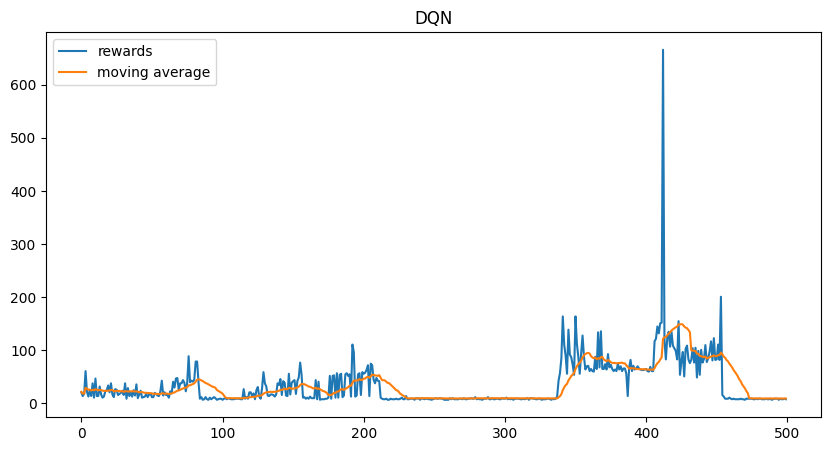

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label = "rewards")
plt.plot(agent.moving_avg_list, label = "moving average")
plt.legend(loc = "upper left")
plt.title("DQN")
plt.show()

REINFORCE
========

In [104]:
class Agent(object):
    def __init__(self):
        # 프로그램의 동작 설정
        self.env = gym.make("CartPole-v1")
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.value_size = 1 # 보상값의 크기

        self.node_num = 12
        
        self.learning_rate = 0.0005
        self.epochs_cnt = 5
        self.model = self.build_model()

        self.discount_rate = 0.95
        self.penalty = -10

        self.episode_num = 500

        self.moving_avg_size = 20

        # data 수집 환경
        self. states, self.action_matrices, self.action_probs, self.rewards = [], [], [], []
        self.DUMMY_ACTION_MATRIX, self.DUMMY_REWARD = np.zeros((1,1,self.action_size)), np.zeros((1,1,self.value_size)) # parameter의 개수를 맞춰주기 위함

        self.reward_list = []
        self.count_list = []
        self.moving_avg_list = []

    class MyModel(tf.keras.Model):
        def train_step(self, data): # overriding for user defined cost function
            # 입력 변수 설정
            in_datas, out_actions = data
            states, action_matrix, rewards = in_datas[0], in_datas[1], in_datas[2]
            with tf.GradientTape() as tape: # for auto gradient 
                y_pred = self.call(states, training = True) # 행동 예측(좌/우). Note : self는 GradientTape Object
                action_probs = K.sum (action_matrix*y_pred, axis = -1) # 확률 계산 (SoftMax)
                loss = -K.log(action_probs) * rewards
            trainable_vars = self.trainable_variables # Model Class 내부에서 Weight & Bias를 저장

            gradients = tape.gradient(loss, trainable_vars) # gradient calc
            self.optimizer.apply_gradients(zip(gradients, trainable_vars)) # 최적화 알고리즘을 통해 입력된 변수에 대한 gradient 적용
            self.compiled_metrics.update_state(out_actions, y_pred)
            return {m.name: m.result() for m in self.metrics}

    def build_model(self):
        input_states = Input(shape = (1,self.state_size), name = "input_states")
        input_action_matrices = Input(shape = (1,self.action_size), name = "input_action_matrices")
        input_rewards = Input(shape = (1,self.value_size), name = "input_rewards")

        x = (input_states)
        x = Dense(self.node_num, activation = "tanh")(x)
        out_actions = Dense(self.action_size, activation = "softmax", name = "output")(x)

        model = self.MyModel(inputs = [input_states, input_action_matrices, input_rewards], outputs = out_actions)

        model.compile(optimizer = Adam(learning_rate = self.learning_rate))

        model.summary()
        return model
    
    def train(self):
        for episode in range(self.episode_num):
            state,_ = self.env.reset()
            self.env.max_episode_steps = 500
            count, reward_tot = self.make_memory(episode, state) # data 수집
            self.train_mini_batch() # model training
            self.clear_memory() # data 삭제

            if count<500:
                reward_tot -= self.penalty

            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list, self.moving_avg_size))

            if(episode % 10 == 0):
                print("episode : {}, moving_avg : {}, rewards_avg : {}".format(episode, self.moving_avg_list[-1],np.mean(self.reward_list)))
        self.save_model()

    def make_memory(self, episode, state) : 
        reward_tot = 0
        count = 0
        reward = np.zeros(self.value_size)
        action_matrix = np.zeros(self.action_size)
        done = False
        while not done:
            count +=1
            state_t = np.reshape(state, [1,1,self.state_size])
            action_matrix_t = np.reshape(action_matrix, [1,1,self.action_size])

            action_prob = self.model.predict([state_t, self.DUMMY_ACTION_MATRIX, self.DUMMY_REWARD], verbose = 0) # action 예측
            # Note : action_matrix & reward -> only for training

            action = np.random.choice(self.action_size, 1, p = action_prob[0][0])[0] # action 선택
            action_matrix = np.zeros(self.action_size) # action matrix : 0 or 1
            action_matrix[action] = 1 # 1 for stochatically chosen action

            state_next, reward, done,_, _ = self.env.step(action)

            if count<500 and done:
                reward = self.penalty

            self.states.append(np.reshape(state_t, [1,self.state_size]))
            self.action_matrices.append(np.reshape(action_matrix, [1, self.action_size]))
            self.action_probs.append(np.reshape(action_prob, [1, self.action_size]))
            self.rewards.append(reward)
            reward_tot += reward
            state = state_next
        return count, reward_tot
    
    def clear_memory(self):
        self.states, self.action_matrices, self.action_probs, self.rewards = [], [], [], []

    def make_discount_rewards(self, rewards):
        discounted_rewards = np.zeros(np.array(rewards).shape)
        running_add = 0
        for t in reversed(range(0,len(rewards))): # 마지막 index부터 반복
            running_add = running_add * self.discount_rate + rewards[t] # 할인된 반환값 계산
            discounted_rewards[t] = running_add
        return discounted_rewards
    
    def train_mini_batch(self):
        discount_rewards = np.array(self.make_discount_rewards(self.rewards)) # 반환값 계산
        discount_rewards_t = np.reshape(discount_rewards, [len(discount_rewards),1, 1])
        states_t = np.array(self.states)
        action_matrices_t = np.array(self.action_matrices)
        action_probs_t = np.array(self.action_probs)
        self.model.fit([states_t, action_matrices_t, discount_rewards_t], y = action_probs_t, epochs=self.epochs_cnt, verbose=0)
        
    def moving_avg(self,data, size = 10):
        if len(data)>size:
            c = np.array(data[len(data) - size : len(data)])
        else:
            c = np.array(data)
        return np.mean(c)
    
    def save_model(self):
        self.model.save("./model/reinforce")
        print("****** end learning")    
    

In [105]:
if __name__ == "__main__":
    agent = Agent()
    agent.train()

Model: "my_model_24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_states (InputLayer)   [(None, 1, 4)]               0         []                            
                                                                                                  
 dense_24 (Dense)            (None, 1, 12)                60        ['input_states[0][0]']        
                                                                                                  
 input_action_matrices (Inp  [(None, 1, 2)]               0         []                            
 utLayer)                                                                                         
                                                                                                  
 input_rewards (InputLayer)  [(None, 1, 1)]               0         []                  

/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode : 0, moving_avg : 23.0, rewards_avg : 22.0
episode : 10, moving_avg : 14.818181818181818, rewards_avg : 13.818181818181818
episode : 20, moving_avg : 15.15, rewards_avg : 14.523809523809524
episode : 30, moving_avg : 14.3, rewards_avg : 13.483870967741936
episode : 40, moving_avg : 14.0, rewards_avg : 13.78048780487805
episode : 50, moving_avg : 16.5, rewards_avg : 14.27450980392157
episode : 60, moving_avg : 15.4, rewards_avg : 13.98360655737705
episode : 70, moving_avg : 15.3, rewards_avg : 14.28169014084507
episode : 80, moving_avg : 19.7, rewards_avg : 15.148148148148149
episode : 90, moving_avg : 23.3, rewards_avg : 16.043956043956044
episode : 100, moving_avg : 31.75, rewards_avg : 18.237623762376238
episode : 110, moving_avg : 39.85, rewards_avg : 20.153153153153152
episode : 120, moving_avg : 35.0, rewards_avg : 20.84297520661157
episode : 130, moving_avg : 37.55, rewards_avg : 22.65648854961832
episode : 140, moving_avg : 45.55, rewards_avg : 24.20567375886525
episode 

INFO:tensorflow:Assets written to: ./model/reinforce/assets


****** end learning


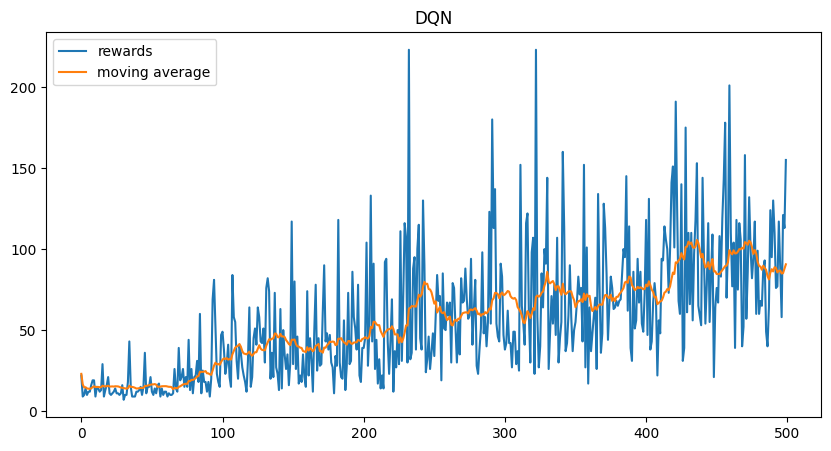

In [106]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label = "rewards")
plt.plot(agent.moving_avg_list, label = "moving average")
plt.legend(loc = "upper left")
plt.title("REINFORCE")
plt.show()

ref : https://goodboychan.github.io/python/reinforcement_learning/pytorch/udacity/2021/05/12/REINFORCE-CartPole.html

In [ ]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

In [17]:
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps', index=0)

In [58]:
env = gym.make("CartPole-v1")
env.observation_space.seed(0)
env.action_space.seed(0)

print("observation space : ", env.observation_space)
print("action space : ", env.action_space)

observation space :  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space :  Discrete(2)


In [59]:
class Policy(nn.Module):
    def __init__(self,state_size = 4, action_size = 2, hidden_size = 32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state) :
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        
        return F.softmax(x, dim = 1)
    
    def act(self, state) : 
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

In [60]:
def reinforce(policy, optimizer, n_episodes = 1000, max_t = 1000, gamma = 1.0, print_every = 100):
    scores_deque = deque(maxlen = 100)
    scores = []
    for e in range(n_episodes):
        saved_log_probs = []
        rewards = []
        state,_ = env.reset()

        # collect trajectories
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _, _ = env.step(action)
            rewards.append(reward)
            if done : 
                break

        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Recalculate the total reward applying discounted factor
        discount = [gamma ** i for i in range(len(rewards)+1)]
        R = sum([a*b for a, b in zip(discount, rewards)])

        # Calculate the loss
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)

        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()

        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if e%print_every == 0:
            print("episode : {}\t Average Score : {:.2f}".format(e, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break
    return scores


In [63]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
scores = reinforce(policy, optimizer, n_episodes=2000)
torch.save(policy.state_dict(),"./model/reinforce_torch")

episode : 0	 Average Score : 16.00
episode : 100	 Average Score : 28.22
episode : 200	 Average Score : 47.33
episode : 300	 Average Score : 82.70
episode : 400	 Average Score : 72.36
episode : 500	 Average Score : 77.09
episode : 600	 Average Score : 70.83
episode : 700	 Average Score : 59.54
episode : 800	 Average Score : 63.33
episode : 900	 Average Score : 69.09
episode : 1000	 Average Score : 69.71
episode : 1100	 Average Score : 100.43
episode : 1200	 Average Score : 107.08
episode : 1300	 Average Score : 194.76
Environment solved in 1201 episodes!	Average Score: 198.87


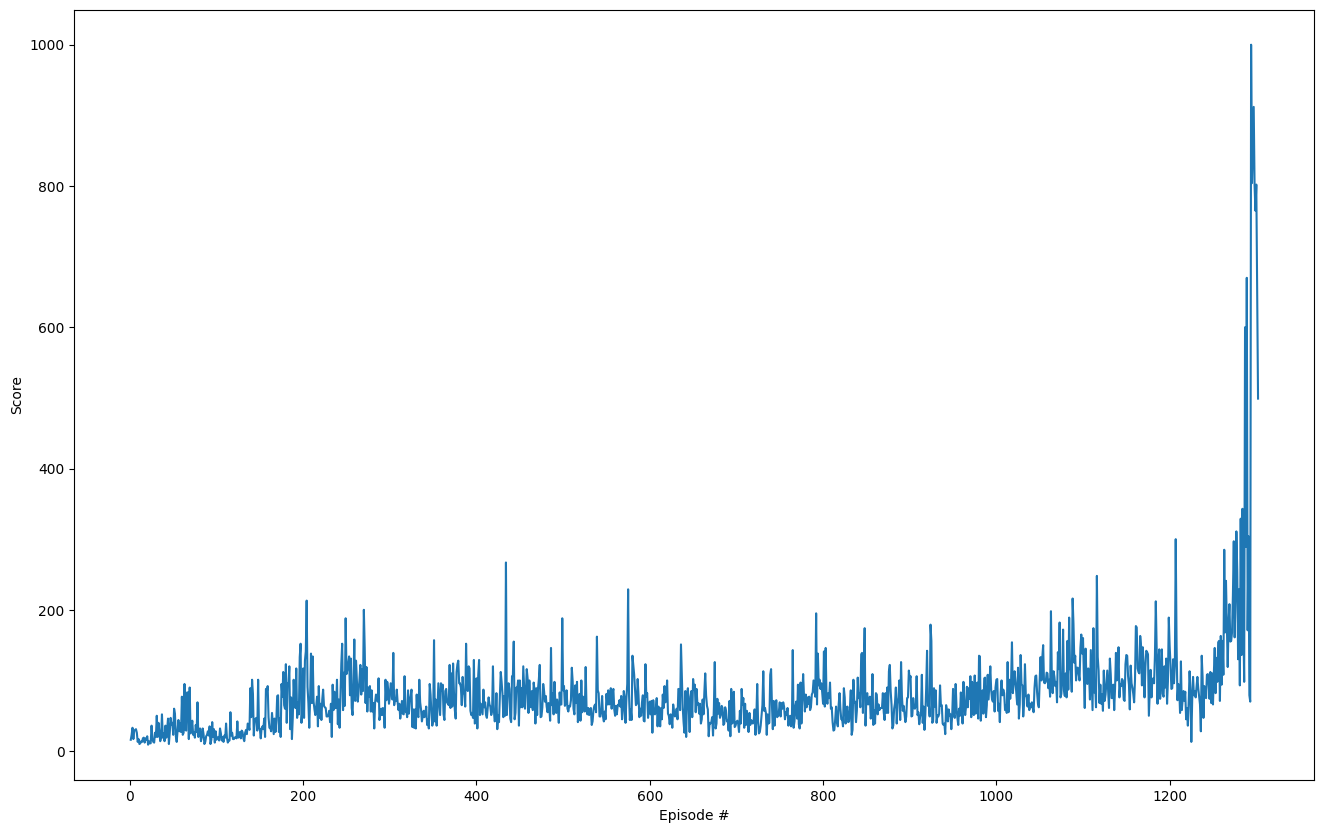

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Advantage Action Critic
=============

In [109]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam, SGD

In [114]:
class Agent(object):
    def __init__(self):
        self.env = gym.make("CartPole-v1")
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.value_size = 1

        self.node_num = 12
        self.learning_rate = 0.002
        self.epoch_cnt = 1
        self.model_actor = self.build_model_actor()
        self.model_critic = self.build_model_critic()

        self.discount_rate = 0.95
        self.penalty = -100

        self.episode_num = 500

        self.moving_avg_size = 20
        self.reward_list = []
        self.count_list = []
        self.moving_avg_list = []

        self.DUMMY_ACTION_MATRIX, self.DUMMY_ADAVANTAGE = np.zeros((1, self.action_size)), np.zeros((1, self.value_size))

    class MyModel(tf.keras.Model):
        def train_step(self, data):
            in_datas, out_action_probs = data
            states, action_matrices, advantages = in_datas[0], in_datas[1], in_datas[2]

            with tf.GradientTape() as tape:
                y_pred = self.call(states, training = True)
                action_probs = K.max(action_matrices*y_pred, axis = -1)
                loss = -K.log(action_probs)*advantages # cost function 
                # cf. REINFOCE : -K.log(action_probs)*rewards
            
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            self.compiled_metrics.update_state(out_action_probs, y_pred)
            return {m.name: m.result() for m in self.metrics}   
        
    def build_model_actor(self): # policy neural network
        input_states = Input(shape = (self.state_size), name = "input_states")
        input_action_matrices = Input(shape = (self.action_size), name = "input_action_matrices")
        input_advantages = Input(shape = (self.value_size), name = "input_advantages")

        x = (input_states)
        x = Dense(self.node_num, activation = "relu")(x)
        out_actions = Dense(self.action_size, activation = "softmax", name = "output")(x)

        model = self.MyModel(inputs = [input_states, input_action_matrices, input_advantages], outputs = out_actions)
        model.compile(optimizer = Adam(learning_rate = self.learning_rate))
        model.summary()
        return model
    
    def build_model_critic(self): # value neural network
        input_states = Input(shape = (self.state_size), name = "input_states")

        x = (input_states)
        x = Dense(self.node_num, activation = "relu")(x)
        out_values = Dense(self.value_size, activation = "linear", name = "output")(x)

        model = tf.keras.models.Model(inputs = [input_states], outputs = [out_values])
        model.compile(optimizer = Adam(learning_rate = self.learning_rate), loss = 'mean_squared_error')
        model.summary()
        return model
    
    def train(self):
        reward_list = []
        count_list = []
        moving_avg_list = []
        for episode in range(self.episode_num):
            state,_ = self.env.reset()
            self.env.max_episode_step = 500
            count, reward_tot = self.make_memory(episode, state) # 데이터 수집

            if count < 500:
                reward_tot -= self.penalty
            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list, self.moving_avg_size))

            if (episode % 10) == 0:
                print("episode : {}, moving_avg : {}, reward_avg : {}".format(episode, self.moving_avg_list[-1], np.mean(self.reward_list)))

        self.save_model()
    
    def make_memory(self, episode, state):
        reward_tot = 0
        count = 0
        reward = np.zeros(self.value_size)
        action_matrix = np.zeros(self.action_size)
        done = False
        while not done:
            count +=1 

            state_t = np.reshape(state, [1, self.state_size])
            action_matrix_t = np.reshape(action_matrix, [1, self.action_size])

            action_prob = self.model_actor.predict([state_t, self.DUMMY_ACTION_MATRIX, self.DUMMY_ADAVANTAGE], verbose = 0)
            action = np.random.choice(self.action_size, 1, p = action_prob[0])[0]

            action_matrix = np.zeros(self.action_size)
            action_matrix[action] = 1

            state_next, reward, done, _, _ = self.env.step(action)

            if count < 500 and done : 
                reward = self.penalty

            # 데이터 수집
            self.train_mini_batch(state, state_next, reward, action_matrix, action_prob, done, count)

            state = state_next
            reward_tot += reward

        return count, reward_tot
    
    def train_mini_batch(self, state, state_next, reward, action_matrix, action_prob, done, count) : 
        state_t = np.reshape(state, [1, self.state_size])
        state_next_t = np.reshape(state_next, [1, self.state_size])
        reward_t = np.reshape(reward, [1, self.value_size])
        action_matrix_t = np.reshape(action_matrix, [1, self.action_size])
        action_prob_t = np.reshape(action_prob, [1, self.action_size])

        advatage_t = np.zeros((1, self.value_size))
        target_t = np.zeros((1, self.value_size))

        # value 예측
        value_t = self.model_critic.predict(state_t, verbose = 0)
        value_next_t = self.model_critic.predict(state_next_t, verbose = 0)

        # advantage 및 target 계산
        if(count<500 and done):
            advatage_t = reward_t - value_t
            target_t = reward_t
        else:
            advatage_t = reward_t + self.discount_rate*value_next_t - value_t
            target_t = reward_t + self.discount_rate*value_next_t
        
        # 모델 학습
        self.model_actor.fit(x = [state_t, action_matrix_t, advatage_t], y = [action_prob_t], epochs = self.epoch_cnt, verbose = 0)
        self.model_critic.fit(x = state_t, y = target_t, epochs = self.epoch_cnt, verbose = 0)
    
    def moving_avg(self, data, size = 10):
        if len(data)>10:
            c = np.array(data[len(data) - size : len(data)])
        else:
            c = np.array(data)
        return np.mean(c)
    
    def save_model(self):
        self.model_actor.save("./model/a2c")
        print("****** end learning")


In [115]:
if __name__ == "__main__":
    agent = Agent()
    agent.train()

Model: "my_model_27"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_states (InputLayer)   [(None, 4)]                  0         []                            
                                                                                                  
 dense_29 (Dense)            (None, 12)                   60        ['input_states[0][0]']        
                                                                                                  
 input_action_matrices (Inp  [(None, 2)]                  0         []                            
 utLayer)                                                                                         
                                                                                                  
 input_advantages (InputLay  [(None, 1)]                  0         []                  

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_states (InputLayer)   [(None, 4)]               0         
                                                                 
 dense_30 (Dense)            (None, 12)                60        
                                                                 
 output (Dense)              (None, 1)                 13        
                                                                 
Total params: 73 (292.00 Byte)
Trainable params: 73 (292.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode : 0, moving_avg : 9.0, reward_avg : 8.0
episode : 10, moving_avg : 15.222222222222221, reward_avg : 13.272727272727273
episode : 20, moving_avg : 17.15, reward_avg : 15.761904761904763
episode : 30, moving_avg : 17.35, reward_avg : 15.258064516129032
episode : 40, moving_avg : 19.85, reward_avg : 17.26829268292683
episode : 50, moving_avg : 20.85, reward_avg : 17.058823529411764
episode : 60, moving_avg : 17.65, reward_avg : 17.065573770491802
episode : 70, moving_avg : 20.65, reward_avg : 17.788732394366196
episode : 80, moving_avg : 22.25, reward_avg : 18.098765432098766
episode : 90, moving_avg : 28.0, reward_avg : 19.813186813186814
episode : 100, moving_avg : 32.55, reward_avg : 20.762376237623762
episode : 110, moving_avg : 42.25, reward_avg : 23.675675675675677
episode : 120, moving_avg : 48.85, reward_avg : 25.239669421487605
episode : 130, moving_avg : 46.3, reward_avg : 26.977099236641223
episode : 140, moving_avg : 40.3, reward_avg : 27.23404255319149
episode : 150, 

INFO:tensorflow:Assets written to: ./model/a2c/assets


****** end learning


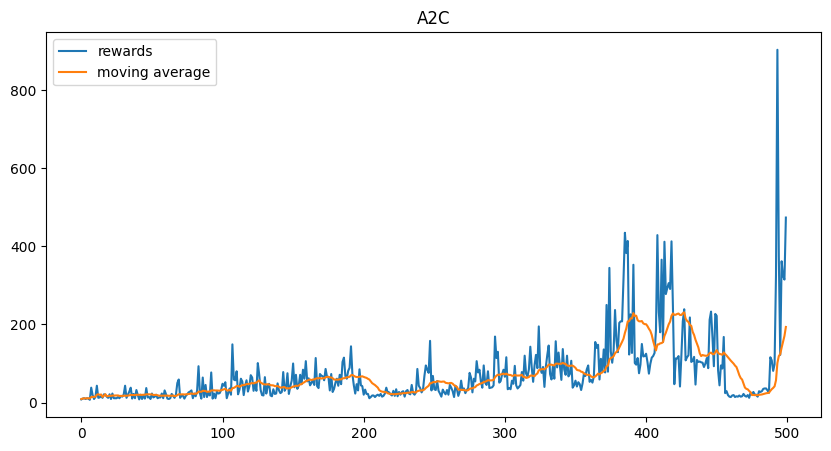

In [117]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label = "rewards")
plt.plot(agent.moving_avg_list, label = "moving average")
plt.legend(loc = "upper left")
plt.title("A2C")
plt.show()

PPO
=======

In [137]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam
import gym
import numpy as np
import random as rand

LOSS_CLIPPING = 0.1 # clipping 범위 설정

class Agent(object) : 
    def __init__(self):
        self.env = gym.make("CartPole-v1")
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.value_size = 1

        self.node_num = 24
        self.learning_rate_actor = 0.0005
        self.learning_rate_critic = 0.0005
        self.epochs_cnt = 5
        self.model_actor = self.build_model_actor()
        self.model_critic = self.build_model_critic()

        self.discount_rate = 0.98
        self.smooth_rate = 0.95 # 미래에 받을 보상을 할인하여 계산할 때 발생할 수 있는 분산 감소
        self.penalty = -400

        self.episode_num = 500
        self.mini_batch_step_size = 32

        self.moving_avg_size = 20
        self.reward_list = []
        self.count_list = []
        self.moving_avg_list = []

        self.states, self.states_next, self.action_matrices = [],[],[]
        self.dones, self.action_probs, self.rewards = [],[],[]
        self.DUMMY_ACTION_MATRIX = np.zeros((1,1,self.action_size))
        self.DUMMY_ADVANTAGE = np.zeros((1,1,self.value_size))
    
    class MyModel(tf.keras.Model):
        def train_step(self,data):
            in_datas, out_action_probs = data
            states, action_matrices, advantages = in_datas[0], in_datas[1], in_datas[2]
            with tf.GradientTape() as tape:
                y_pred = self.call(states, training = True)
                new_policy = K.max(action_matrices * y_pred, axis = -1) # 신규 정책 확률 -> action_matrix = [1,0] or [0,1]
                old_policy = K.max(action_matrices * out_action_probs, axis = -1)
                r = new_policy/(old_policy)
                clipped = K.clip(r, 1 - LOSS_CLIPPING, 1 + LOSS_CLIPPING)
                loss = -K.minimum(r*advantages, clipped*advantages)

            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            self.compiled_metrics.update_state(out_action_probs, y_pred)
            return {m.name: m.result() for m in self.metrics}  
    
    def build_model_actor(self):
        input_states = Input(shape = (1, self.state_size), name = "input_states")
        input_action_matrices = Input(shape = (1, self.action_size), name = "input_action_matrices")
        input_advantages = Input(shape = (1, self.value_size), name = "input_advantages")
        x = (input_states)
        x = Dense(self.node_num, activation = 'relu')(x)
        out_actions = Dense(self.action_size, activation = "softmax", name = "output")(x)

        model = self.MyModel(inputs = [input_states, input_action_matrices, input_advantages], outputs = out_actions)
        model.compile(optimizer = Adam(lr = self.learning_rate_actor))

        model.summary()
        return model
    
    def build_model_critic(self):
        input_states = Input(shape = (1,self.state_size), name = "input_states")
        x = (input_states)
        x = Dense(self.node_num, activation = "relu")(x)
        out_values = Dense(self.value_size, activation = "linear", name = "output")(x)

        model = tf.keras.models.Model(inputs = [input_states], outputs = [out_values])
        model.compile(optimizer = Adam(lr = self.learning_rate_critic), loss = "mean_squared_error")

        model.summary()
        return model
    
    def train(self):
        for episode in range(self.episode_num):
            state,_ = self.env.reset()
            self.env.max_episode_steps = 500 # 최대 실행 횟수
            count, reward_tot = self.make_memory(episode, state) # 게임이 종료될 때까지 경험을 수집(train_mini_batch 호출 -> mini_batch_step_size 단위로 나누어서 모델 학습)
            self.train_mini_batch() # 나머지 데이터 학습
            self.clear_memory() # cf. REINFOCE는 하나의 episode가 끝날 때까지 경험을 계속 수집

            if count < 500:
                reward_tot -= self.penalty

            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list, self.moving_avg_size))

            if(episode % 10 == 0):
                print("episode : {}, moving_avg : {}, rewards_avg : {}".format(episode, self.moving_avg_list[-1], np.mean(self.reward_list)))

        self.save_model()
    
    def make_memory(self, episode, state):
        reward_tot = 0
        count = 0
        reward = np.zeros(self.value_size)
        advantage = np.zeros(self.value_size)
        target = np.zeros(self.value_size)
        action_matrix = np.zeros(self.action_size)
        done = False

        while not done:
            count += 1
            state_t = np.reshape(state, [1,1,self.state_size])
            action_matrix_t = np.reshape(action_matrix, [1,1,self.action_size])
            action_prob = self.model_actor.predict([state_t, self.DUMMY_ACTION_MATRIX, self.DUMMY_ADVANTAGE], verbose = 0)
            
            action = np.random.choice(self.action_size, 1, p = action_prob[0][0])[0]
            action_matrix = np.zeros(self.action_size)
            action_matrix[action] = 1
            state_next, reward, done, _ , _ = self.env.step(action)

            state_next_t = np.reshape(state_next,[1,1,self.state_size])

            if count < 500 and done:
                reward = self.penalty

            self.states.append(np.reshape(state_t, [1,self.state_size]))
            self.states_next.append(np.reshape(state_next_t, [1,self.state_size]))
            self.action_matrices.append(np.reshape(action_matrix, [1,self.action_size]))
            self.dones.append(np.reshape(0 if done else 1, [1,self.value_size])) # 종료 변수 설정
            self.action_probs.append(np.reshape(action_prob, [1, self.action_size]))
            self.rewards.append(np.reshape(reward, [1, self.value_size]))

            if(count % self.mini_batch_step_size == 0): # 모델 학습 : mini_batch_step_size에 의해 설정된 주기로 모델을 학습
                self.train_mini_batch()
                self.clear_memory()
            reward_tot += reward
            state = state_next

        return count, reward_tot
    
    def make_gae(self, values, values_next, rewards, dones):
        delta_adv, delta_tar, adv, target = 0,0,0,0
        advantages = np.zeros(np.array(values).shape)
        targets = np.zeros(np.array(values).shape)
        for t in reversed(range(0,len(rewards))): # 마지막 index부터 반복
            delta_adv = rewards[t] + self.discount_rate * values_next[t] * dones[t] - values[t] # dones는 게임이 종료된 경우 values_next의 영향을 고려하지 않기 위해 도입
            delta_tar = rewards[t] + self.discount_rate*values_next[t]*dones[t]
            adv = delta_adv + self.smooth_rate*self.discount_rate*dones[t]*adv
            target = delta_tar + self.smooth_rate*self.discount_rate*dones[t]*target
            advantages[t] = adv
            targets[t] = target
        return advantages, targets
    
    def train_mini_batch(self):
        if len(self.states) == 0:
            return
        
        states_t = np.array(self.states)
        states_next_t = np.array(self.states_next)
        action_matrices_t = np.array(self.action_matrices)
        action_probs_t = np.array(self.action_probs)
        rewards_t = np.array(self.rewards)

        # 가치 예측
        values = self.model_critic.predict(states_t, verbose = 0)
        values_next = self.model_critic.predict(states_next_t, verbose = 0)
        
        # GAE 계산
        advantages, targets = self.make_gae(values, values_next, self.rewards, self.dones)
        advantages_t = np.array(advantages)
        targets_t = np.array(targets)

        self.model_actor.fit([states_t, action_matrices_t, advantages_t],[action_probs_t], epochs = self.epochs_cnt, verbose = 0)
        self.model_critic.fit(states_t, targets_t, epochs = self.epochs_cnt, verbose = 0)

    def clear_memory(self):
        self.states, self.states_next, self.action_matrices = [],[],[]
        self.dones, self.action_probs, self.rewards = [],[],[]

    def moving_avg(self, data, size = 10):
        if len(data) > size : 
            c = np.array(data[len(data) - size : len(data)])
        else:
            c = np.array(data)
        return np.mean(c)
    
    def save_model(self):
        self.model_actor.save("./model/ppo")
        print("*****end learning")

if __name__ == "__main__":
    agent = Agent()
    agent.train()

            

Model: "my_model_36"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_states (InputLayer)   [(None, 1, 4)]               0         []                            
                                                                                                  
 dense_47 (Dense)            (None, 1, 24)                120       ['input_states[0][0]']        
                                                                                                  
 input_action_matrices (Inp  [(None, 1, 2)]               0         []                            
 utLayer)                                                                                         
                                                                                                  
 input_advantages (InputLay  [(None, 1, 1)]               0         []                  

/opt/homebrew/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode : 0, moving_avg : 24.0, rewards_avg : 23.0
episode : 10, moving_avg : 23.818181818181817, rewards_avg : 22.818181818181817
episode : 20, moving_avg : 22.05, rewards_avg : 21.142857142857142
episode : 30, moving_avg : 18.45, rewards_avg : 19.35483870967742
episode : 40, moving_avg : 18.75, rewards_avg : 19.48780487804878
episode : 50, moving_avg : 26.85, rewards_avg : 21.901960784313726
episode : 60, moving_avg : 27.6, rewards_avg : 21.81967213114754
episode : 70, moving_avg : 23.4, rewards_avg : 22.04225352112676
episode : 80, moving_avg : 24.05, rewards_avg : 22.123456790123456
episode : 90, moving_avg : 21.25, rewards_avg : 21.64835164835165
episode : 100, moving_avg : 22.4, rewards_avg : 21.980198019801982
episode : 110, moving_avg : 22.5, rewards_avg : 21.62162162162162
episode : 120, moving_avg : 17.8, rewards_avg : 21.123966942148762
episode : 130, moving_avg : 19.0, rewards_avg : 21.068702290076335
episode : 140, moving_avg : 22.2, rewards_avg : 21.134751773049647
episod

INFO:tensorflow:Assets written to: ./model/ppo/assets


*****end learning


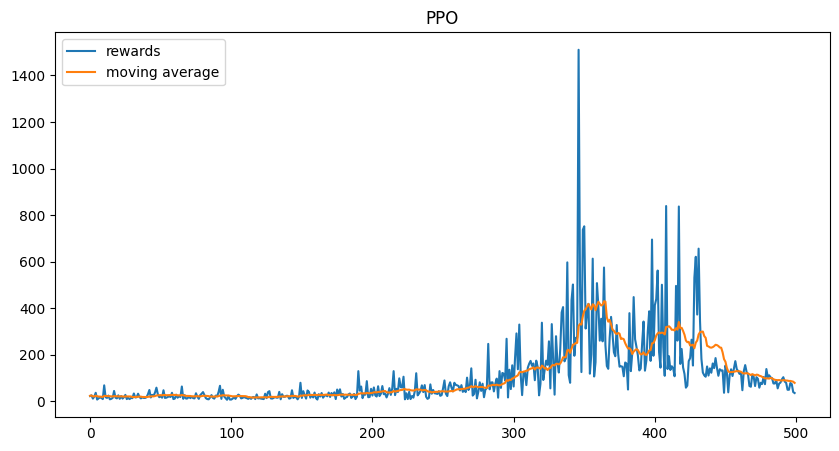

In [138]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label = "rewards")
plt.plot(agent.moving_avg_list, label = "moving average")
plt.legend(loc = "upper left")
plt.title("PPO")
plt.show()

PPO Fine tuning
=====

In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam
import gym
import numpy as np
import random

In [3]:
LOSS_CLIPPING = 0.2
class Agent(object):
    def __init__(self):
        self.env = gym.make("CartPole-v1")
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.value_size = 1
        self.node_num = 24
        self.learning_rate_actor = 0.0005
        self.learning_rate_critic = 0.0005
        self.epochs_cnt = 5
        self.model_actor = self.build_model_actor()
        self.model_critic = self.build_model_critic()

        self.discount_rate = 0.98
        self.smooth_rate = 0.95
        self.penalty = -400

        self.episode_num = 500
        self.mini_batch_step_size = 32

        self.moving_avg_size = 20
        self.reward_list = []
        self.count_list = []
        self.moving_avg_list = []

        self.states, self.states_next, self.action_matrices = [],[],[]
        self.dones, self.action_probs, self.rewards = [],[],[]
        self.DUMMY_ACTION_MATRIX = np.zeros((1,1,self.action_size))
        self.DUMMY_ADVANTAGE = np.zeros((1,1,self.value_size))

    class MyModel(tf.keras.Model):
        def train_step(self, data):
            in_datas, out_action_probs = data
            states, action_matrices, advantages = in_datas[0], in_datas[1], in_datas[2]
            with tf.GradientTape() as tape:
                y_pred = self.call(states, training = True)
                new_policy = K.max(action_matrices * y_pred, axis = -1)
                old_policy = K.max(action_matrices * out_action_probs, axis = -1)
                r = new_policy/(old_policy)
                clipped = K.clip(r, 1-LOSS_CLIPPING, 1+LOSS_CLIPPING)
                loss = -K.minimum(r*advantages, clipped*advantages)
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            self.compiled_metrics.update_state(out_action_probs, y_pred)
            return {m.name: m.result() for m in self.metrics}  
        
    def build_model_actor(self):
        input_states = Input(shape = (1,self.state_size), name = "input_states")
        input_action_matrices = Input(shape = (1,self.action_size), name = "input_action_matrices")
        input_advantages = Input(shape = (1,self.value_size), name = "input_advantages")
        x = (input_states)
        x = Dense(self.node_num, activation = "relu", kernel_initializer = "glorot_normal")(x)
        out_actions = Dense(self.action_size, activation = "softmax", name = "output")(x)
        model = self.MyModel(inputs = [input_states, input_action_matrices, input_advantages], outputs = out_actions)
        model.compile(optimizer = Adam(learning_rate=self.learning_rate_actor))
        model.summary()
        return model
    
    def build_model_critic(self):
        input_states = Input(shape = (1, self.state_size), name = "input_states")
        x = (input_states)
        x = Dense(self.node_num, activation = "relu", kernel_initializer = "glorot_normal")(x)
        out_values = Dense(self.value_size, activation = "linear", name = "output")(x)
        model = tf.keras.models.Model(inputs = [input_states], outputs = [out_values])
        model.compile(optimizer = Adam(learning_rate = self.learning_rate_critic), loss = "mean_squared_error")
        model.summary()
        return model
    
    def train(self):
        for episode in range(self.episode_num):
            state,_ = self.env.reset()
            self.env.max_episode_steps = 500
            count, reward_tot = self.make_memory(episode, state)
            self.train_mini_batch()
            self.clear_memory()

            if count < 500:
                reward_tot -= self.penalty
            
            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list,self.moving_avg_size))

            if(episode % 10 == 0 ):
                print("episode : {}, moving_avg : {}, rewards_avg : {}".format(episode, self.moving_avg_list[-1], np.mean(self.reward_list)))
        self.save_model()

    def moving_avg(self, data, size = 10):
        if len(data)>size : 
            c = np.array(data[len(data) - size : len(data)])
        else:
            c = np.array(data)
        return np.mean(c)
    
    def clear_memory(self):
        self.states, self.states_next, self.action_matrices = [],[],[]
        self.dones, self.action_probs, self.rewards = [],[],[]

    def make_memory(self, episode, state):
        reward_tot, count = 0,0
        reward, advantage, target, action_matrix = np.zeros(self.value_size),np.zeros(self.value_size),np.zeros(self.value_size), np.zeros(self.action_size)
        done = False

        while not done:
            count+=1
            state_t =  np.reshape(self.normalize(state), [1,1,self.state_size])
            action_matrix_t = np.reshape(action_matrix, [1,1, self.action_size])
            action_prob = self.model_actor.predict([state_t, self.DUMMY_ACTION_MATRIX, self.DUMMY_ADVANTAGE], verbose = 0)
            action = np.random.choice(self.action_size, 1, p = action_prob[0][0])[0]
            action_matrix = np.zeros(self.action_size)
            action_matrix[action] = 1
            state_next, reward, done, _, _ = self.env.step(action)
            state_next_t = np.reshape(self.normalize(state_next), [1,1,self.state_size])

            if count < 500 and done:
                reward = self.penalty
            
            self.states.append(np.reshape(state_t, [1,self.state_size]))
            self.states_next.append(np.reshape(state_next_t, [1,self.state_size]))
            self.action_matrices.append(np.reshape(action_matrix,[1, self.action_size]))
            self.dones.append(np.reshape(0 if done else 1, [1, self.value_size]))
            self.action_probs.append(np.reshape(action_prob, [1, self.action_size]))
            self.rewards.append(np.reshape(reward, [1,self.value_size]))

            if (count % self.mini_batch_step_size == 0):
                self.train_mini_batch()
                self.clear_memory()
            reward_tot += reward
            state = state_next

        return count, reward_tot

    def make_gae(self, values, values_next, rewards, dones):
        delta_adv, delta_tar, adv, target = 0,0,0,0
        advantages = np.zeros(np.array(values).shape)
        targets = np.zeros(np.array(values).shape)
        for t in reversed(range(0,len(rewards))):
            delta_adv = rewards[t] + self.discount_rate*values_next[t]*dones[t] - values[t]
            delta_tar = rewards[t] + self.discount_rate*values_next[t]*dones[t]
            adv = delta_adv + self.smooth_rate*self.discount_rate*dones[t]*adv
            target = delta_tar + self.smooth_rate*self.discount_rate*dones[t]*target
            advantages[t] = adv
            targets[t] = target

        return advantages, targets
    
    def normalize(self, x):
        norm = np.linalg.norm(x)
        if norm == 0 :
            return x
        return x / norm
    
    def train_mini_batch(self):
        if len(self.states) == 0:
            return
        states_t = np.array(self.states)
        states_next_t = np.array(self.states_next)
        action_matrices_t = np.array(self.action_matrices)
        action_probs_t = np.array(self.action_probs)
        rewards_t = np.array(self.rewards)
        values = self.model_critic.predict(states_t, verbose = 0)
        values_next = self.model_critic.predict(states_next_t, verbose = 0)

        advantages, targets = self.make_gae(values, values_next, self.rewards, self.dones)
        advantages_t = np.array(advantages)
        targets_t = np.array(targets)
        self.model_actor.fit([states_t, action_matrices_t, advantages_t], [action_probs_t], epochs = self.epochs_cnt, verbose = 0)
        self.model_critic.fit(states_t, targets_t, epochs = self.epochs_cnt, verbose = 0)

    def save_model(self):
        self.model_actor.save("./model/ppo_tuned")
        print("*****end learning")

if __name__ == "__main__":
    agent = Agent()
    agent.train()


Model: "my_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_states (InputLayer)   [(None, 1, 4)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 1, 24)                120       ['input_states[0][0]']        
                                                                                                  
 input_action_matrices (Inp  [(None, 1, 2)]               0         []                            
 utLayer)                                                                                         
                                                                                                  
 input_advantages (InputLay  [(None, 1, 1)]               0         []                     

/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode : 0, moving_avg : 19.0, rewards_avg : 18.0
episode : 10, moving_avg : 38.81818181818182, rewards_avg : 37.81818181818182
episode : 20, moving_avg : 43.85, rewards_avg : 41.666666666666664
episode : 30, moving_avg : 55.05, rewards_avg : 48.29032258064516
episode : 40, moving_avg : 75.05, rewards_avg : 57.46341463414634
episode : 50, moving_avg : 81.25, rewards_avg : 60.8235294117647
episode : 60, moving_avg : 78.35, rewards_avg : 63.98360655737705
episode : 70, moving_avg : 93.05, rewards_avg : 69.61971830985915
episode : 80, moving_avg : 92.7, rewards_avg : 70.82716049382717
episode : 90, moving_avg : 101.1, rewards_avg : 76.31868131868131
episode : 100, moving_avg : 123.5, rewards_avg : 81.05940594059406
episode : 110, moving_avg : 146.55, rewards_avg : 88.7927927927928
episode : 120, moving_avg : 175.15, rewards_avg : 96.44628099173553
episode : 130, moving_avg : 195.15, rewards_avg : 104.87786259541984
episode : 140, moving_avg : 252.45, rewards_avg : 118.43262411347517
epis

INFO:tensorflow:Assets written to: ./model/ppo_tuned/assets


*****end learning


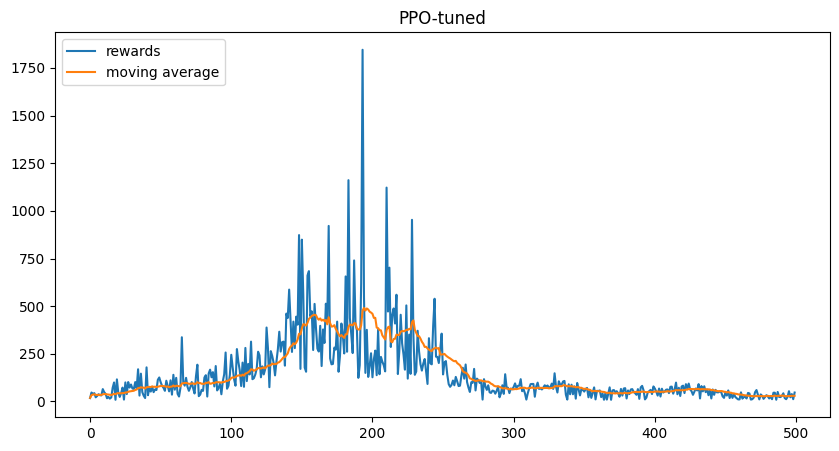

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label = "rewards")
plt.plot(agent.moving_avg_list, label = "moving average")
plt.legend(loc = "upper left")
plt.title("PPO-tuned")
plt.show()

PPO with Grid Search
============

In [49]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam
import gym
import numpy as np
import random as rand

class Agent(object):
    def __init__(self, config_data):
        self.env = gym.make('CartPole-v1')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.value_size = 1
        
        self.layer_num_actor = config_data['layer_num_actor']
        self.node_num_actor = config_data['node_num_actor']
        self.epochs_actor = config_data['epochs_actor']
        self.layer_num_critic = config_data['layer_num_critic']
        self.node_num_critic = config_data['node_num_critic']
        self.epochs_critic = config_data['epochs_critic']
        
        self.learning_rate_actor = config_data['learning_rate_actor']
        self.learning_rate_critic = config_data['learning_rate_critic']
        self.discount_rate = config_data['discount_rate']
        self.smooth_rate = config_data['smooth_rate']
        self.penalty = config_data['penalty']
        self.mini_batch_step_size = config_data['mini_batch_step_size']
        self.loss_clipping = config_data['loss_clipping']

        self.episode_num = 200
        self.moving_avg_size = 20
        
        self.model_actor = self.build_model_actor()
        self.model_critic = self.build_model_critic()
 
        self.states, self.states_next, self.action_matrixs, self.dones, self.action_probs, self.rewards = [],[],[],[],[],[]
        self.DUMMY_ACTION_MATRIX, self.DUMMY_ADVANTAGE, self.DUMMY_LOSS_CLIPPING = np.zeros((1,1,self.action_size)), np.zeros((1,1,self.value_size)), np.zeros((1,1,self.value_size))
    
        self.reward_list= []
        self.count_list = []
        self.moving_avg_list = []
        
    class MyModel(tf.keras.Model):
        def train_step(self, data):
            in_datas, out_action_probs = data
            states, action_matrixs, advantages, loss_clipping = in_datas[0], in_datas[1], in_datas[2], in_datas[3]

            with tf.GradientTape() as tape:
                y_pred = self.call(states, training=True)
                new_policy = K.max(action_matrixs*y_pred, axis=-1)   
                old_policy = K.max(action_matrixs*out_action_probs, axis=-1)    
                r = new_policy/(old_policy)
                
                LOSS_CLIPPING = K.mean(loss_clipping)
                
                loss = -K.minimum(r*advantages, K.clip(r, 1-LOSS_CLIPPING, 1+LOSS_CLIPPING)*advantages)
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            self.compiled_metrics.update_state(out_action_probs, y_pred)
            return {m.name: m.result() for m in self.metrics}  
            
    def build_model_actor(self):
        input_states = Input(shape=(1,self.state_size), name='input_states')
        input_action_matrixs = Input(shape=(1,self.action_size), name='input_action_matrixs')
        input_advantages = Input(shape=(1,self.value_size), name='input_advantages')
        input_loss_clipping = Input(shape=(1,self.value_size), name='input_loss_clipping')        
        
        x = (input_states)
        for i in range(1,self.layer_num_actor+1):            
            x = Dense(self.node_num_actor, activation="relu", kernel_initializer='glorot_normal')(x)
        out_actions = Dense(self.action_size, activation='softmax', name='output')(x)
        
        model = self.MyModel(inputs=[input_states, input_action_matrixs, input_advantages, input_loss_clipping],
                             outputs=out_actions)
        model.compile(optimizer=Adam(learning_rate=self.learning_rate_actor))
        
        return model
    
    def build_model_critic(self):
        input_states = Input(shape=(1,self.state_size), name='input_states')
        
        x = (input_states)
        for i in range(1,self.layer_num_critic+1):
            x = Dense(self.node_num_critic, activation="relu", kernel_initializer='glorot_normal')(x)
        out_values = Dense(self.value_size, activation='linear', name='output')(x)
        
        model = tf.keras.models.Model(inputs=[input_states], outputs=[out_values])
        model.compile(optimizer=Adam(lr=self.learning_rate_critic),
                      loss = "binary_crossentropy"
                     )
        return model

    def train(self):
        for episode in range(self.episode_num):

            state = self.env.reset()
            state = state[0]

            count, reward_tot = self.make_memory(episode, state)
            self.train_mini_batch()
            self.clear_memory()
            
            if count < 500:
                reward_tot = reward_tot-self.penalty
            
            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list,self.moving_avg_size))                
            

    def moving_avg(self, data, size=10):
        if len(data) > size:
            c = np.array(data[len(data)-size:len(data)]) 
        else:
            c = np.array(data) 
        return np.mean(c)
    
    def clear_memory(self):
        self.states, self.states_next, self.action_matrixs, self.done, self.action_probs, self.rewards = [],[],[],[],[],[]
        
    def make_memory(self, episode, state):
        reward_tot = 0
        count = 0
        reward = np.zeros(self.value_size)
        advantage = np.zeros(self.value_size)
        target = np.zeros(self.value_size)
        action_matrix = np.zeros(self.action_size)
        done = False
        
        while not done:
            count+=1

            state_t = np.reshape(self.normalize(state),[1, 1, self.state_size])
            action_matrix_t = np.reshape(action_matrix,[1, 1, self.action_size])
            
            action_prob = self.model_actor.predict([state_t, self.DUMMY_ACTION_MATRIX, self.DUMMY_ADVANTAGE, self.DUMMY_LOSS_CLIPPING], verbose = 0)
            action = np.random.choice(self.action_size, 1, p=action_prob[0][0])[0]
            action_matrix = np.zeros(self.action_size) #초기화
            action_matrix[action] = 1

            state_next, reward, done, none, none2 = self.env.step(action)
            
            state_next_t = np.reshape(self.normalize(state_next),[1, 1, self.state_size])
            
            if count < 500 and done:
                reward = self.penalty 
        
            self.states.append(np.reshape(state_t, [1,self.state_size]))
            self.states_next.append(np.reshape(state_next_t, [1,self.state_size]))
            self.action_matrixs.append(np.reshape(action_matrix, [1,self.action_size]))
            self.dones.append(np.reshape(0 if done else 1, [1,self.value_size]))
            self.action_probs.append(np.reshape(action_prob, [1,self.action_size]))
            self.rewards.append(np.reshape(reward, [1,self.value_size]))
            
            if(count % self.mini_batch_step_size == 0):
                self.train_mini_batch()
                self.clear_memory()

            reward_tot += reward
            state = state_next
            
        return count, reward_tot
    
    def make_gae(self, values, values_next, rewards, dones):
        delta_adv, delta_tar, adv, target = 0, 0, 0, 0
        advantages = np.zeros(np.array(values).shape)
        targets = np.zeros(np.array(values).shape)
        for t in reversed(range(0, len(rewards))):
            delta_adv = rewards[t] + self.discount_rate * values_next[t] * dones[t] - values[t]
            delta_tar = rewards[t] + self.discount_rate * values_next[t] * dones[t]
            adv = delta_adv + self.smooth_rate *  self.discount_rate * dones[t] * adv
            target = delta_tar + self.smooth_rate * self.discount_rate * dones[t] * target
            advantages[t] = adv
            targets[t] = target
        return advantages, targets

    def normalize(self, x):
        norm = np.linalg.norm(x)
        if norm == 0: 
            return x
        return x / norm

    def train_mini_batch(self):
        
        if len(self.states) == 0:
            return
        
        states_t = np.array(self.states)
        states_next_t = np.array(self.states_next)
        action_matrixs_t = np.array(self.action_matrixs)
        action_probs_t = np.array(self.action_probs)
        loss_clipping = [self.loss_clipping for j in range(len(self.states))]
        loss_clipping_t = np.reshape(loss_clipping, [len(self.states),1,1])
        
        values = self.model_critic.predict(states_t, verbose = 0)
        values_next = self.model_critic.predict(states_next_t, verbose = 0)
        
        advantages, targets = self.make_gae(values, values_next, self.rewards, self.dones)
        advantages_t = np.array(advantages)
        targets_t = np.array(targets)
        
        self.model_actor.fit([states_t, action_matrixs_t, advantages_t, loss_clipping_t], [action_probs_t], 
                             epochs=self.epochs_actor, verbose=0)
        self.model_critic.fit(states_t, targets_t, 
                              epochs=self.epochs_critic, verbose=0)       
        

if __name__ == "__main__":

    def random_select():
        config_data = {
            'layer_num_actor':rand.randint(1,2),
            'node_num_actor':rand.randint(12,128),
            'epochs_actor':rand.randint(3,6),
            'layer_num_critic':rand.randint(1,2),
            'node_num_critic':rand.randint(12,128),
            'epochs_critic':rand.randint(3,6),
            
            'learning_rate_actor' :rand.uniform(0.0001,0.001),
            'learning_rate_critic':rand.uniform(0.0001,0.001),
            'discount_rate'       :rand.uniform(0.9,0.99),
            'smooth_rate'       :rand.uniform(0.9,0.99),
            'penalty'             :rand.randint(-500,-10),
            'mini_batch_step_size':rand.randint(4,80),
            'loss_clipping'       :rand.uniform(0.1,0.3)
        }
        return config_data

    results = []
    print("***** start random search *****")        
    for i in range(10):
        config_data = random_select()
        agent = Agent(config_data)
        print("*config:", config_data)
        agent.train()
        result = []
        result.append(config_data)
        result.append(agent.moving_avg_list[len(agent.moving_avg_list)-1])
        result.append(np.mean(agent.reward_list))
        results.append(result)
        print("*result:", i, agent.moving_avg_list[len(agent.moving_avg_list)-1], np.mean(agent.reward_list))
        print("-"*100)
    print("***** end random search *****")    
    

***** start random search *****
*config: {'layer_num_actor': 1, 'node_num_actor': 91, 'epochs_actor': 3, 'layer_num_critic': 1, 'node_num_critic': 30, 'epochs_critic': 3, 'learning_rate_actor': 0.00034918756695421653, 'learning_rate_critic': 0.0005521552970388685, 'discount_rate': 0.9745490661334361, 'smooth_rate': 0.9391079032678123, 'penalty': -411, 'mini_batch_step_size': 38, 'loss_clipping': 0.24362261634613142}


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


*result: 0 47.55 27.76
----------------------------------------------------------------------------------------------------
*config: {'layer_num_actor': 1, 'node_num_actor': 46, 'epochs_actor': 6, 'layer_num_critic': 1, 'node_num_critic': 115, 'epochs_critic': 4, 'learning_rate_actor': 0.0001877536864237271, 'learning_rate_critic': 0.0008793096754546734, 'discount_rate': 0.9024701069212598, 'smooth_rate': 0.9405551868454759, 'penalty': -429, 'mini_batch_step_size': 60, 'loss_clipping': 0.2594742199797563}


*result: 1 48.3 32.34
----------------------------------------------------------------------------------------------------
*config: {'layer_num_actor': 2, 'node_num_actor': 100, 'epochs_actor': 5, 'layer_num_critic': 2, 'node_num_critic': 117, 'epochs_critic': 6, 'learning_rate_actor': 0.0008758949151877156, 'learning_rate_critic': 0.0007303981281296128, 'discount_rate': 0.9789617137276573, 'smooth_rate': 0.9307908768135839, 'penalty': -252, 'mini_batch_step_size': 29, 'loss_clipping': 0.1872063582399598}


*result: 2 11.1 10.89
----------------------------------------------------------------------------------------------------
*config: {'layer_num_actor': 1, 'node_num_actor': 76, 'epochs_actor': 6, 'layer_num_critic': 1, 'node_num_critic': 61, 'epochs_critic': 5, 'learning_rate_actor': 0.0001498640062779636, 'learning_rate_critic': 0.00014694964589459544, 'discount_rate': 0.9829081354657372, 'smooth_rate': 0.963884709874954, 'penalty': -298, 'mini_batch_step_size': 25, 'loss_clipping': 0.29175317855915095}


*result: 3 115.15 56.24
----------------------------------------------------------------------------------------------------
*config: {'layer_num_actor': 2, 'node_num_actor': 59, 'epochs_actor': 3, 'layer_num_critic': 2, 'node_num_critic': 106, 'epochs_critic': 3, 'learning_rate_actor': 0.0006464737715231064, 'learning_rate_critic': 0.0006827948492274287, 'discount_rate': 0.9415275757285885, 'smooth_rate': 0.9412178573668694, 'penalty': -23, 'mini_batch_step_size': 73, 'loss_clipping': 0.25608346736252763}


*result: 4 170.65 132.3
----------------------------------------------------------------------------------------------------
*config: {'layer_num_actor': 1, 'node_num_actor': 34, 'epochs_actor': 4, 'layer_num_critic': 1, 'node_num_critic': 31, 'epochs_critic': 3, 'learning_rate_actor': 0.0006680535624009576, 'learning_rate_critic': 0.0008638428728546697, 'discount_rate': 0.9825615326200406, 'smooth_rate': 0.960844098974686, 'penalty': -337, 'mini_batch_step_size': 24, 'loss_clipping': 0.22648428110532604}


*result: 5 424.95 144.9
----------------------------------------------------------------------------------------------------
*config: {'layer_num_actor': 2, 'node_num_actor': 70, 'epochs_actor': 3, 'layer_num_critic': 2, 'node_num_critic': 52, 'epochs_critic': 3, 'learning_rate_actor': 0.0009293947342578112, 'learning_rate_critic': 0.0008855339530889553, 'discount_rate': 0.9815805776204428, 'smooth_rate': 0.914161987538308, 'penalty': -283, 'mini_batch_step_size': 18, 'loss_clipping': 0.15145329615305936}


*result: 6 539.7 545.065
----------------------------------------------------------------------------------------------------
*config: {'layer_num_actor': 2, 'node_num_actor': 17, 'epochs_actor': 5, 'layer_num_critic': 2, 'node_num_critic': 59, 'epochs_critic': 4, 'learning_rate_actor': 0.0002411951906507635, 'learning_rate_critic': 0.0002716762204795446, 'discount_rate': 0.9174812828562142, 'smooth_rate': 0.9012068265047591, 'penalty': -273, 'mini_batch_step_size': 56, 'loss_clipping': 0.26147812721636976}


*result: 7 70.2 42.41
----------------------------------------------------------------------------------------------------
*config: {'layer_num_actor': 2, 'node_num_actor': 31, 'epochs_actor': 4, 'layer_num_critic': 2, 'node_num_critic': 36, 'epochs_critic': 6, 'learning_rate_actor': 0.0002754332516657941, 'learning_rate_critic': 0.00031724138024483107, 'discount_rate': 0.9508259596572762, 'smooth_rate': 0.9843290384902129, 'penalty': -235, 'mini_batch_step_size': 69, 'loss_clipping': 0.23275730501137187}


*result: 8 81.25 38.535
----------------------------------------------------------------------------------------------------
*config: {'layer_num_actor': 2, 'node_num_actor': 14, 'epochs_actor': 5, 'layer_num_critic': 2, 'node_num_critic': 41, 'epochs_critic': 6, 'learning_rate_actor': 0.00042410280627505745, 'learning_rate_critic': 0.00019224327849935087, 'discount_rate': 0.9704383164213156, 'smooth_rate': 0.9679531792263635, 'penalty': -31, 'mini_batch_step_size': 7, 'loss_clipping': 0.28839560943266423}
*result: 9 448.55 114.82
----------------------------------------------------------------------------------------------------
***** end random search *****


In [52]:
avg_list = []
for i in range(0,10):
    avg_list.append([results[i][2],i])
avg_list.sort(reverse=True)
avg_list

[[545.065, 6],
 [144.9, 5],
 [132.3, 4],
 [114.82, 9],
 [56.24, 3],
 [42.41, 7],
 [38.535, 8],
 [32.34, 1],
 [27.76, 0],
 [10.89, 2]]

In [53]:
best_config = results[6][0]
results[6]

[{'layer_num_actor': 2,
  'node_num_actor': 70,
  'epochs_actor': 3,
  'layer_num_critic': 2,
  'node_num_critic': 52,
  'epochs_critic': 3,
  'learning_rate_actor': 0.0009293947342578112,
  'learning_rate_critic': 0.0008855339530889553,
  'discount_rate': 0.9815805776204428,
  'smooth_rate': 0.914161987538308,
  'penalty': -283,
  'mini_batch_step_size': 18,
  'loss_clipping': 0.15145329615305936},
 539.7,
 545.065]

In [54]:
best_config

{'layer_num_actor': 2,
 'node_num_actor': 70,
 'epochs_actor': 3,
 'layer_num_critic': 2,
 'node_num_critic': 52,
 'epochs_critic': 3,
 'learning_rate_actor': 0.0009293947342578112,
 'learning_rate_critic': 0.0008855339530889553,
 'discount_rate': 0.9815805776204428,
 'smooth_rate': 0.914161987538308,
 'penalty': -283,
 'mini_batch_step_size': 18,
 'loss_clipping': 0.15145329615305936}

In [55]:
LOSS_CLIPPING = 0.15145329615305936
class Agent(object):
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.value_size = 1

        self.layer_num_actor = 2
        self.node_num_actor = 70
        self.epochs_actor = 3
        self.layer_num_critic = 2
        self.node_num_critic = 52
        self.epochs_critic = 3
        
        self.learning_rate_actor = 0.0009293947342578112
        self.learning_rate_critic = 0.0008855339530889553
        self.discount_rate = 0.9815805776204428
        self.smooth_rate = 0.914161987538308
        self.penalty = -283
        self.mini_batch_step_size = 18
   
        self.episode_num = 300
        
        self.moving_avg_size = 20
        
        self.model_actor = self.build_model_actor()
        self.model_critic = self.build_model_critic()
 
        self.states, self.states_next, self.action_matrices, self.dones, self.action_probs, self.rewards = [],[],[],[],[],[]
        self.DUMMY_ACTION_MATRIX, self.DUMMY_ADVANTAGE= np.zeros((1,1,self.action_size)), np.zeros((1,1,self.value_size))
        self.DUMMY_LOSS_CLIPPING = np.zeros((1,1,self.value_size))

        self.reward_list= []
        self.count_list = []
        self.moving_avg_list = []
        
    class MyModel(tf.keras.Model):
        def train_step(self,data):
            in_datas, out_action_probs = data
            states, action_matrices, advatages = in_datas[0], in_datas[1], in_datas[2],
            with tf.GradientTape() as tape : 
                y_pred = self.call(states, training = True)
                new_policy = K.max(action_matrices * y_pred, axis = -1)
                old_policy = K.max(action_matrices * out_action_probs, axis = -1)
                r = new_policy/(old_policy)
                loss = -K.minimum(r*advatages, K.clip(r, 1-LOSS_CLIPPING, 1+LOSS_CLIPPING) * advatages)
            
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            self.compiled_metrics.update_state(out_action_probs, y_pred)
            return {m.name: m.result() for m in self.metrics}  
    
    def build_model_actor(self):
        input_states = Input(shape = (1, self.state_size), name = "input_states")
        input_action_matrices = Input(shape = (1,self.action_size), name = "input_action_matrices")
        input_advantages = Input(shape= (1, self.value_size), name = "input_advantages")

        x = (input_states)
        for i in range(1, self.layer_num_actor + 1) : 
            x = Dense(self.node_num_actor, activation = "relu", kernel_initializer = "glorot_normal")(x)
        out_actions = Dense(self.action_size, activation = "softmax", name = "output")(x)

        model = self.MyModel(inputs = [input_states, input_action_matrices, input_advantages], outputs = out_actions)
        model.compile(optimizer = Adam(learning_rate = self.learning_rate_actor))
        return model
    
    def build_model_critic(self):
        input_states = Input(shape = (1,self.state_size), name = "input_states")
        x = (input_states)
        for i in range(1, self.layer_num_critic + 1) : 
            x = Dense(self.node_num_critic, activation = "relu", kernel_initializer = "glorot_normal")(x)
        out_values = Dense(self.value_size, activation = "linear", name = "output")(x)
        model = tf.keras.models.Model(inputs = [input_states], outputs = [out_values])
        model.compile(optimizer = Adam(learning_rate = self.learning_rate_critic), loss = "binary_crossentropy")

        return model
    
    def train(self):
        for episode in range(self.episode_num):
            state,_ = self.env.reset()
            count, reward_tot = self.make_memory(episode, state)
            self.train_mini_batch()
            self.clear_memory()

            if count < 500:
                reward_tot -= self.penalty

            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list, self.moving_avg_size))
            if(episode % 10 == 0):
                print("episode:{}, moving_avg:{}, rewards_avg:{}".format(episode, self.moving_avg_list[-1], np.mean(self.reward_list)))
        self.save_model()

    def moving_avg(self, data, size = 10):
        if len(data)>size:
            c = np.array(data[len(data) - size : len(data)])
        else:
            c = np.array(data)
        return np.mean(c)
    
    def clear_memory(self):
        self.states, self.states_next, self.action_matrices, self.dones = [],[],[],[]
        self.action_probs, self.rewards = [],[]

    def make_memory(self, episode, state):
        reward_tot, count = 0,0
        reward, advantage, target = np.zeros(self.value_size),np.zeros(self.value_size),np.zeros(self.value_size)
        action_matrix = np.zeros(self.action_size)
        done = False

        while not done:
            count+=1
            state_t = np.reshape(self.normalize(state), [1,1,self.state_size])
            action_matrix_t = np.reshape(self.normalize(action_matrix),[1,1,self.action_size])
            action_prob = self.model_actor.predict([state_t, self.DUMMY_ACTION_MATRIX, self.DUMMY_ADVANTAGE],verbose = 0)
            action = np.random.choice(self.action_size, 1, p = action_prob[0][0])[0]
            action_matrix = np.zeros(self.action_size)
            action_matrix[action] = 1
            state_next, reward, done, _, _ = self.env.step(action)

            state_next_t = np.reshape(self.normalize(state_next), [1,1,self.state_size])

            if count<500 and done:
                reward = self.penalty

            self.states.append(np.reshape(state_t, [1, self.state_size]))
            self.states_next.append(np.reshape(state_next_t, [1,self.state_size]))
            self.action_matrices.append(np.reshape(action_matrix, [1, self.action_size]))
            self.dones.append(np.reshape(0 if done else 1, [1,self.value_size]))
            self.action_probs.append(np.reshape(action_prob, [1, self.action_size]))
            self.rewards.append(np.reshape(reward, [1, self.value_size]))

            if(count%self.mini_batch_step_size == 0):
                self.train_mini_batch()
                self.clear_memory()
            reward_tot += reward
            state = state_next
        return count, reward_tot
    
    def make_gae(self, values, values_next, rewards, dones):
        delta_adv, delta_tar, adv, target = 0,0,0,0
        advantages = np.zeros(np.array(values).shape)
        targets = np.zeros(np.array(values).shape)
        for t in reversed(range(0,len(rewards))):
            delta_adv = rewards[t] + self.discount_rate*values_next[t]*dones[t]-values[t]
            delta_tar = rewards[t] + self.discount_rate*values_next[t]*dones[t]
            adv = delta_adv + self.smooth_rate * self.discount_rate * self.dones[t] * adv
            target = delta_tar + self.smooth_rate*self.discount_rate*self.dones[t]*target
            advantages[t] = adv
            targets[t] = target
        return advantages, targets
    
    def normalize(self, x):
        norm = np.linalg.norm(x)
        if norm == 0 :
            return x
        return x/norm
    
    def train_mini_batch(self):
            
            if len(self.states) == 0:
                return
            
            states_t = np.array(self.states)
            states_next_t = np.array(self.states_next)
            action_matrices_t = np.array(self.action_matrices)
            action_probs_t = np.array(self.action_probs)
            rewards_t = np.array(self.rewards)

            values = self.model_critic.predict(states_t,verbose = 0)
            values_next = self.model_critic.predict(states_next_t,verbose = 0)
            
            advantages, targets = self.make_gae(values, values_next, self.rewards, self.dones)
            advantages_t = np.array(advantages)
            targets_t = np.array(targets)

            self.model_actor.fit([states_t, action_matrices_t, advantages_t], [action_probs_t], epochs=5, verbose=0)
            self.model_critic.fit(states_t, targets_t, epochs=5, verbose=0) 

    def save_model(self):
        self.model_actor.save("./model/ppo_tuned_grid")
        print("*****end learing")

if __name__ == "__main__":
    agent = Agent()
    agent.train()

episode:0, moving_avg:15.0, rewards_avg:14.0
episode:10, moving_avg:34.27272727272727, rewards_avg:33.27272727272727
episode:20, moving_avg:95.0, rewards_avg:90.19047619047619
episode:30, moving_avg:189.4, rewards_avg:133.3548387096774
episode:40, moving_avg:143.2, rewards_avg:115.5609756097561
episode:50, moving_avg:105.45, rewards_avg:122.01960784313725
episode:60, moving_avg:579.4, rewards_avg:267.39344262295083
episode:70, moving_avg:1191.8, rewards_avg:423.2676056338028
episode:80, moving_avg:1033.15, rewards_avg:456.39506172839504
episode:90, moving_avg:613.9, rewards_avg:465.05494505494505
episode:100, moving_avg:465.4, rewards_avg:458.0495049504951
episode:110, moving_avg:301.45, rewards_avg:435.4234234234234
episode:120, moving_avg:210.75, rewards_avg:417.0082644628099
episode:130, moving_avg:205.2, rewards_avg:400.12213740458014
episode:140, moving_avg:203.95, rewards_avg:386.64539007092196
episode:150, moving_avg:205.1, rewards_avg:374.158940397351
episode:160, moving_avg:22

INFO:tensorflow:Assets written to: ./model/ppo_tuned_grid/assets


*****end learing


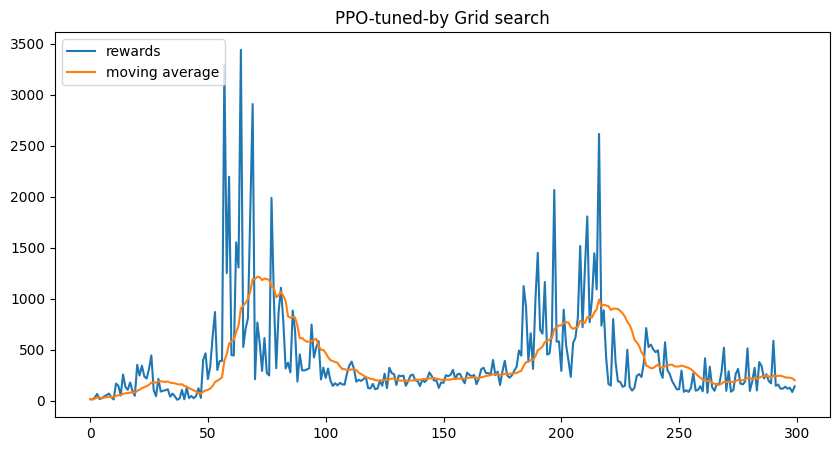

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label = "rewards")
plt.plot(agent.moving_avg_list, label = "moving average")
plt.legend(loc = "upper left")
plt.title("PPO-tuned-by Grid search")
plt.show()

Test of Bayesian Optimization
=========

In [59]:
from bayes_opt import BayesianOptimization

def black_box_function(x,y):
    return -x**2 - (y-1)**2 + 1

pbounds = {'x' : (2, 4), 'y' : (-3, 3)} # parameter 변경 범위
optimizer = BayesianOptimization(
    f = black_box_function,
    pbounds= pbounds,
    random_state= 1
)

optimizer.maximize(
    init_points=2, # 목표함수 실행 횟수
    n_iter=3 # 최적화 횟수
)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 1         | -7.135    | 2.834     | 1.322     |
| 2         | -7.78     | 2.0       | -1.186    |
| 3         | -7.11     | 2.218     | -0.7867   |
| 4         | -12.4     | 3.66      | 0.9608    |
| 5         | -6.999    | 2.23      | -0.7392   |


In [60]:
# 최적화 실행 횟수가 많은 경우 유용
print(optimizer.max)

{'target': -6.999472814518675, 'params': {'x': 2.2303920156083024, 'y': -0.7392021938893159}}


In [61]:
# 단계별로 최적화 과정을 저장
for i, res in enumerate(optimizer.res):
    print("Iteration {} : \n\t {}".format(i, res))

Iteration 0 : 
	 {'target': -7.135455292718879, 'params': {'x': 2.8340440094051482, 'y': 1.3219469606529488}}
Iteration 1 : 
	 {'target': -7.779531005607566, 'params': {'x': 2.0002287496346898, 'y': -1.1860045642089614}}
Iteration 2 : 
	 {'target': -7.109925819441113, 'params': {'x': 2.2175526295255183, 'y': -0.7867249801593896}}
Iteration 3 : 
	 {'target': -12.397162416009818, 'params': {'x': 3.660003815774634, 'y': 0.9608275029525108}}
Iteration 4 : 
	 {'target': -6.999472814518675, 'params': {'x': 2.2303920156083024, 'y': -0.7392021938893159}}


In [62]:
# parameter 범위 변경 -> 새로운 parameter 범위를 지정해서 최적화 가능
optimizer.set_bounds(new_bounds={"x" : (-2,3)})
optimizer.maximize(
    init_points= 0,
    n_iter=5
)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 6         | -2.942    | 1.98      | 0.8567    |
| 7         | -0.4597   | 1.096     | 1.508     |
| 8         | 0.5304    | -0.6807   | 1.079     |
| 9         | -5.33     | -1.526    | 3.0       |
| 10        | -5.419    | -2.0      | -0.5552   |


In [64]:
optimizer.probe(
    params = {"x" : 0.5, "y" : 0.7},
    lazy = True # maximize 함수가 호출된 이후 probe 함수가 동작할 수 있도록 지정
)

optimizer.probe(
    params = [-0.3,0.1],
    lazy = True
)

optimizer.maximize(init_points=0, n_iter=0)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 11        | 0.66      | 0.5       | 0.7       |
| 12        | 0.1       | -0.3      | 0.1       |


In [66]:
# 학습 과정에서 발생한 event를 json 파일 형식으로 저장
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

logger = JSONLogger(path = "./bayesian/logs.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)
optimizer.maximize(
    init_points=2,
    n_iter = 3
)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 14        | -3.854    | -1.069    | -0.9266   |
| 15        | 0.4113    | -0.01616  | 0.2329    |
| 16        | 0.9784    | 0.09597   | 1.111     |
| 17        | -3.715    | 0.8455    | 3.0       |
| 18        | 0.9097    | -0.1919   | 0.7688    |
| 19        | 0.7608    | -0.1961   | 1.448     |


In [70]:
# 기록된 event를 다시 불러와서 재사용
from bayes_opt.util import load_logs

new_optimizer = BayesianOptimization(
    f = black_box_function,
    pbounds = {"x" : (-2,2), "y" : (-2,2)},
    verbose = 2,
    random_state=7
)

load_logs(new_optimizer, logs = ["./bayesian/logs.json"])
new_optimizer.maximize(
    init_points=2,
    n_iter=3
)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 1         | -1.887    | -1.695    | 1.12      |
| 2         | 0.928     | -0.2464   | 0.8939    |
| 3         | -12.0     | 2.0       | -2.0      |
| 4         | -3.049    | 2.0       | 1.222     |
| 5         | -1.161    | -1.077    | 2.0       |


Application to RL
==========

In [114]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers.legacy import Adam
import gym
import numpy as np
import random as rand
from bayes_opt import BayesianOptimization

class Agent(object):
    def __init__(self, config_data):
        self.env = gym.make("CartPole-v1")
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.value_size = 1

        self.layer_num_actor = int(round(config_data['layer_num_actor'],0))
        self.node_num_actor = int(round(config_data['node_num_actor'],0))
        self.epochs_actor = int(round(config_data['epochs_actor'],0))
        self.layer_num_critic = int(round(config_data['layer_num_critic'],0))
        self.node_num_critic = int(round(config_data['node_num_critic'],0))
        self.epochs_critic = int(round(config_data['epochs_critic'],0))

        self.learning_rate_actor = config_data['learning_rate_actor']
        self.learning_rate_critic = config_data['learning_rate_critic']
        self.discount_rate = config_data['discount_rate']
        self.smooth_rate = config_data['smooth_rate']
        self.penalty = int(round(config_data['penalty'],0))
        self.mini_batch_step_size = int(round(config_data['mini_batch_step_size'],0))
        self.loss_clipping = config_data['loss_clipping']
        self.episode_num = 100
        self.moving_avg_size = 20

        self.model_actor = self.build_model_actor()
        self.model_critic = self.build_model_critic()

        self.states,self.states_next, self.action_matrices, self.dones = [],[],[],[]
        self.action_probs, self.rewards = [],[]

        self.DUMMY_ACTION_MATRIX = np.zeros((1,1,self.action_size))
        self.DUMMY_ADVANTAGE = np.zeros((1,1,self.value_size))

        self.reward_list = []
        self.count_list = []
        self.moving_avg_list = []
        
    class MyModel(tf.keras.Model):
        def train_step(self, data):
            in_datas, out_action_probs = data
            states, action_matrixs, advantages, loss_clipping = in_datas[0], in_datas[1], in_datas[2], in_datas[3]

            with tf.GradientTape() as tape:
                y_pred = self.call(states, training=True)
                new_policy = K.max(action_matrixs*y_pred, axis=-1)   
                old_policy = K.max(action_matrixs*out_action_probs, axis=-1)    
                r = new_policy/(old_policy)
                
                LOSS_CLIPPING = K.mean(loss_clipping)
                
                loss = -K.minimum(r*advantages, K.clip(r, 1-LOSS_CLIPPING, 1+LOSS_CLIPPING)*advantages)
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            self.compiled_metrics.update_state(out_action_probs, y_pred)
            return {m.name: m.result() for m in self.metrics}  
            
    def build_model_actor(self):
        input_states = Input(shape=(1,self.state_size), name='input_states')
        input_action_matrices = Input(shape=(1,self.action_size), name='input_action_matrices')
        input_advantages = Input(shape=(1,self.value_size), name='input_advantages')
        
        x = (input_states)
        for i in range(1,self.layer_num_actor+1):            
            x = Dense(self.node_num_actor, activation="relu", kernel_initializer='glorot_normal')(x)
        out_actions = Dense(self.action_size, activation='softmax', name='output')(x)
        
        model = self.MyModel(inputs=[input_states, input_action_matrices, input_advantages],
                             outputs=out_actions)
        model.compile(optimizer=Adam(learning_rate=self.learning_rate_actor))
        
        return model
    
    def build_model_critic(self):
        input_states = Input(shape=(1,self.state_size), name='input_states')
        
        x = (input_states)
        for i in range(1,self.layer_num_critic+1):
            x = Dense(self.node_num_critic, activation="relu", kernel_initializer='glorot_normal')(x)
        out_values = Dense(self.value_size, activation='linear', name='output')(x)
        
        model = tf.keras.models.Model(inputs=[input_states], outputs=[out_values])
        model.compile(optimizer=Adam(learning_rate=self.learning_rate_critic),
                      loss = "binary_crossentropy"
                     )
        return model

    def train(self):
        for episode in range(self.episode_num):

            state,_ = self.env.reset()

            count, reward_tot = self.make_memory(episode, state)
            self.train_mini_batch()
            self.clear_memory()
            
            if count < 500:
                reward_tot = reward_tot-self.penalty
            
            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list,self.moving_avg_size))                
            

    def moving_avg(self, data, size=10):
        if len(data) > size:
            c = np.array(data[len(data)-size:len(data)]) 
        else:
            c = np.array(data) 
        return np.mean(c)
    
    def clear_memory(self):
        self.states, self.states_next, self.action_matrices, self.done, self.action_probs, self.rewards = [],[],[],[],[],[]
        
    def make_memory(self, episode, state):
        reward_tot = 0
        count = 0
        reward = np.zeros(self.value_size)
        advantage = np.zeros(self.value_size)
        target = np.zeros(self.value_size)
        action_matrix = np.zeros(self.action_size)
        done = False
        
        while not done:
            count+=1

            state_t = np.reshape(self.normalize(state),[1, 1, self.state_size])
            action_matrix_t = np.reshape(action_matrix,[1, 1, self.action_size])
            
            action_prob = self.model_actor.predict([state_t, self.DUMMY_ACTION_MATRIX, self.DUMMY_ADVANTAGE], verbose = 0)
            action = np.random.choice(self.action_size, 1, p=action_prob[0][0])[0]
            action_matrix = np.zeros(self.action_size) #초기화
            action_matrix[action] = 1

            state_next, reward, done, none, none2 = self.env.step(action)
            
            state_next_t = np.reshape(self.normalize(state_next),[1, 1, self.state_size])
            
            if count < 500 and done:
                reward = self.penalty 
        
            self.states.append(np.reshape(state_t, [1,self.state_size]))
            self.states_next.append(np.reshape(state_next_t, [1,self.state_size]))
            self.action_matrices.append(np.reshape(action_matrix, [1,self.action_size]))
            self.dones.append(np.reshape(0 if done else 1, [1,self.value_size]))
            self.action_probs.append(np.reshape(action_prob, [1,self.action_size]))
            self.rewards.append(np.reshape(reward, [1,self.value_size]))
            
            if(count % self.mini_batch_step_size == 0):
                self.train_mini_batch()
                self.clear_memory()

            reward_tot += reward
            state = state_next
            
        return count, reward_tot
    
    def make_gae(self, values, values_next, rewards, dones):
        delta_adv, delta_tar, adv, target = 0, 0, 0, 0
        advantages = np.zeros(np.array(values).shape)
        targets = np.zeros(np.array(values).shape)
        for t in reversed(range(0, len(rewards))):
            delta_adv = rewards[t] + self.discount_rate * values_next[t] * dones[t] - values[t]
            delta_tar = rewards[t] + self.discount_rate * values_next[t] * dones[t]
            adv = delta_adv + self.smooth_rate *  self.discount_rate * dones[t] * adv
            target = delta_tar + self.smooth_rate * self.discount_rate * dones[t] * target
            advantages[t] = adv
            targets[t] = target
        return advantages, targets

    def normalize(self, x):
        norm = np.linalg.norm(x)
        if norm == 0: 
            return x
        return x / norm

    def train_mini_batch(self):
        
        if len(self.states) == 0:
            return
        
        states_t = np.array(self.states)
        states_next_t = np.array(self.states_next)
        action_matrices_t = np.array(self.action_matrices)
        action_probs_t = np.array(self.action_probs)
        loss_clipping = [self.loss_clipping for j in range(len(self.states))]
        loss_clipping_t = np.reshape(loss_clipping, [len(self.states),1,1])
        
        values = self.model_critic.predict(states_t, verbose = 0)
        values_next = self.model_critic.predict(states_next_t, verbose = 0)
        
        advantages, targets = self.make_gae(values, values_next, self.rewards, self.dones)
        advantages_t = np.array(advantages)
        targets_t = np.array(targets)

        self.model_actor.fit([states_t, action_matrices_t, advantages_t, loss_clipping_t], [action_probs_t], 
                             epochs=self.epochs_actor, verbose=0)
        self.model_critic.fit(states_t, targets_t, 
                              epochs=self.epochs_critic, verbose=0)   
        
if __name__ == "__main__":

    def black_box_function(layer_num_actor, node_num_actor, epochs_actor, 
                           layer_num_critic, node_num_critic, epochs_critic,
                           learning_rate_actor, learning_rate_critic,
                           discount_rate, smooth_rate, 
                           penalty, mini_batch_step_size, loss_clipping
                          ):
        config_data = {
            'layer_num_actor':layer_num_actor,
            'node_num_actor':node_num_actor,
            'epochs_actor':epochs_actor,
            'layer_num_critic':layer_num_critic,
            'node_num_critic':node_num_critic,
            'epochs_critic':epochs_critic,
            
            'learning_rate_actor' :learning_rate_actor,
            'learning_rate_critic':learning_rate_critic,
            'discount_rate'       :discount_rate,
            'smooth_rate'       :smooth_rate,
            'penalty'             :penalty,
            'mini_batch_step_size':mini_batch_step_size,
            'loss_clipping'       :loss_clipping
        }
        agent = Agent(config_data)
        agent.train()
        return np.mean(agent.reward_list)
        
    pbounds = {
        'layer_num_actor': (1, 2),
        'node_num_actor': (12, 128),
        'epochs_actor': (3, 6),
        'layer_num_critic': (1, 2),
        'node_num_critic': (12, 128),
        'epochs_critic': (3, 6),

        'learning_rate_actor': (0.0001, 0.001),
        'learning_rate_critic': (0.0001, 0.001),
        'discount_rate': (0.9, 0.99),
        'smooth_rate': (0.9, 0.99),
        'penalty': (-500, -10),
        'mini_batch_step_size': (4, 80),
        'loss_clipping': (0.1, 0.3)
    }

    optimizer = BayesianOptimization(
        f=black_box_function,
        pbounds=pbounds,
        random_state=1,
    )

    optimizer.maximize(
        init_points=5,
        n_iter=20
    )




|   iter    |  target   | discou... | epochs... | epochs... | layer_... | layer_... | learni... | learni... | loss_c... | mini_b... | node_n... | node_n... |  penalty  | smooth... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 36.15     | 0.9375    | 5.161     | 3.0       | 1.302     | 1.147     | 0.0001831 | 0.0002676 | 0.1691    | 34.15     | 74.5      | 60.63     | -164.2    | 0.9184    |
| 2         | 23.44     | 0.979     | 3.082     | 5.011     | 1.417     | 1.559     | 0.0002263 | 0.0002783 | 0.2601    | 77.59     | 48.36     | 92.31     | -70.57    | 0.9805    |
| 3         | 18.52     | 0.9077    | 3.117     | 3.509     | 1.878     | 1.098     | 0.000479  | 0.0009621 | 0.2066    | 56.58     | 48.6      | 91.63     | -91.03    | 0.9016    |
| 4         | 27.83     | 0.9675    | 5.967     | 5.244     | 1.28      | 1.789     | 0.00

/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


| 6         | 116.4     | 0.9033    | 5.101     | 4.038     | 1.41      | 1.393     | 0.0008247 | 0.0009908 | 0.2715    | 31.58     | 44.41     | 25.38     | -492.5    | 0.9089    |


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


| 7         | 322.6     | 0.9424    | 3.826     | 5.102     | 1.779     | 1.849     | 0.0005856 | 0.0007415 | 0.2949    | 34.85     | 61.93     | 28.71     | -420.1    | 0.9347    |


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


| 8         | 205.4     | 0.9561    | 5.377     | 4.037     | 1.091     | 1.536     | 0.000949  | 0.0004892 | 0.1358    | 17.45     | 90.82     | 122.4     | -133.1    | 0.9446    |


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


| 9         | 153.8     | 0.9352    | 3.343     | 5.206     | 1.199     | 1.062     | 0.0009595 | 0.0001351 | 0.2367    | 44.62     | 119.1     | 51.09     | -47.23    | 0.9792    |


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


| 10        | 45.49     | 0.9682    | 5.624     | 4.292     | 1.77      | 1.288     | 0.0002582 | 0.0005829 | 0.2948    | 36.58     | 83.53     | 23.39     | -362.3    | 0.9589    |


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


| 11        | 76.46     | 0.9226    | 3.466     | 5.953     | 1.183     | 1.364     | 0.0004184 | 0.0002818 | 0.2086    | 10.69     | 119.6     | 18.01     | -368.9    | 0.9539    |


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


| 12        | 58.37     | 0.9216    | 5.941     | 4.988     | 1.431     | 1.603     | 0.000164  | 0.0009361 | 0.2232    | 17.56     | 75.3      | 126.5     | -123.4    | 0.9677    |


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


| 13        | 22.09     | 0.9274    | 3.438     | 5.431     | 1.271     | 1.792     | 0.0001699 | 0.000275  | 0.2057    | 17.54     | 85.69     | 24.01     | -315.8    | 0.9555    |


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


| 14        | 23.22     | 0.9223    | 4.879     | 4.707     | 1.951     | 1.056     | 0.0003292 | 0.0002664 | 0.2299    | 61.55     | 55.41     | 118.3     | -390.9    | 0.928     |


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


| 15        | 20.24     | 0.9873    | 4.764     | 4.072     | 1.858     | 1.077     | 0.0004358 | 0.0004647 | 0.2783    | 39.85     | 55.34     | 21.24     | -484.9    | 0.9184    |


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


| 16        | 19.54     | 0.9692    | 3.7       | 5.935     | 1.737     | 1.245     | 0.0001858 | 0.0007444 | 0.1418    | 72.77     | 38.84     | 66.25     | -443.6    | 0.954     |


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


| 17        | 20.31     | 0.9384    | 4.063     | 5.433     | 1.973     | 1.702     | 0.0002531 | 0.0004836 | 0.2822    | 20.95     | 14.45     | 56.22     | -360.9    | 0.9325    |


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


| 18        | 19.02     | 0.9874    | 4.124     | 5.531     | 1.317     | 1.099     | 0.0006489 | 0.0001439 | 0.1877    | 64.63     | 66.42     | 46.25     | -324.1    | 0.9804    |


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


| 19        | 159.3     | 0.9468    | 5.848     | 4.31      | 1.338     | 1.942     | 0.0002304 | 0.0001433 | 0.1504    | 17.42     | 119.2     | 72.16     | -343.8    | 0.9182    |


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


| 20        | 17.75     | 0.9827    | 5.733     | 4.683     | 1.874     | 1.492     | 0.0002364 | 0.0008774 | 0.1281    | 73.26     | 27.1      | 24.63     | -295.4    | 0.9433    |


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


| 21        | 18.68     | 0.9408    | 5.98      | 3.106     | 1.338     | 1.537     | 0.0005013 | 0.0001813 | 0.2879    | 67.19     | 68.89     | 95.38     | -89.85    | 0.9136    |


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


| 22        | 40.31     | 0.9408    | 4.317     | 4.081     | 1.172     | 1.664     | 0.0003451 | 0.0009641 | 0.1131    | 57.73     | 115.6     | 47.91     | -106.4    | 0.9336    |


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


| 23        | 48.52     | 0.9044    | 3.296     | 4.876     | 1.686     | 1.858     | 0.0002184 | 0.0006983 | 0.2079    | 47.25     | 91.28     | 68.71     | -215.7    | 0.9858    |


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


| 24        | 21.47     | 0.9605    | 3.133     | 4.512     | 1.243     | 1.388     | 0.0001527 | 0.0009078 | 0.1728    | 76.53     | 87.38     | 82.61     | -336.0    | 0.9774    |


/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


| 25        | 170.6     | 0.9475    | 5.208     | 5.257     | 1.277     | 1.617     | 0.0006155 | 0.0007829 | 0.1399    | 27.28     | 97.4      | 106.6     | -411.5    | 0.9122    |


In [115]:
target_list = []
i=0
for res in optimizer.res:
    target_list.append([res["target"], i])
    i=i+1
target_list.sort(reverse=True)    
target_list

[[322.6, 6],
 [205.43, 7],
 [170.58, 24],
 [159.34, 18],
 [153.85, 8],
 [116.41, 5],
 [76.46, 10],
 [58.37, 11],
 [48.52, 22],
 [45.49, 9],
 [40.31, 21],
 [36.15, 0],
 [27.83, 3],
 [27.68, 4],
 [23.44, 1],
 [23.22, 13],
 [22.09, 12],
 [21.47, 23],
 [20.31, 16],
 [20.24, 14],
 [19.54, 15],
 [19.02, 17],
 [18.68, 20],
 [18.52, 2],
 [17.75, 19]]

In [118]:
best_config = optimizer.res[6]['params']
print("*result:" , optimizer.res[6]['params'])


*result: {'discount_rate': 0.9424314474626744, 'epochs_actor': 3.8263907525104206, 'epochs_critic': 5.10213931376879, 'layer_num_actor': 1.778686801150168, 'layer_num_critic': 1.8485149414580322, 'learning_rate_actor': 0.0005856265308413472, 'learning_rate_critic': 0.000741506055175181, 'loss_clipping': 0.29489767592501814, 'mini_batch_step_size': 34.85187404129374, 'node_num_actor': 61.933814958080205, 'node_num_critic': 28.708607449638404, 'penalty': -420.12600085916023, 'smooth_rate': 0.9347099545989747}


In [117]:
count_100 = 0
for res in optimizer.res:
    if(res["target"] >= 100):
        count_100 = count_100+1
print("count_100:", count_100)

count_100: 6


In [120]:
best_config

{'discount_rate': 0.9424314474626744,
 'epochs_actor': 3.8263907525104206,
 'epochs_critic': 5.10213931376879,
 'layer_num_actor': 1.778686801150168,
 'layer_num_critic': 1.8485149414580322,
 'learning_rate_actor': 0.0005856265308413472,
 'learning_rate_critic': 0.000741506055175181,
 'loss_clipping': 0.29489767592501814,
 'mini_batch_step_size': 34.85187404129374,
 'node_num_actor': 61.933814958080205,
 'node_num_critic': 28.708607449638404,
 'penalty': -420.12600085916023,
 'smooth_rate': 0.9347099545989747}

In [129]:

# -*- coding: utf-8 -*-
#batch normalize
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam
import gym
import numpy as np
import random as rand

LOSS_CLIPPING = best_config['loss_clipping']
class Agent(object):
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.value_size = 1

        self.layer_num_actor = int(round(best_config['layer_num_actor'],0))
        self.node_num_actor = int(round(best_config['node_num_actor'],0))
        self.epochs_actor = int(round(best_config['epochs_actor'],0))
        
        self.layer_num_critic = int(round(best_config['layer_num_critic'],0))
        self.node_num_critic = int(round(best_config['node_num_critic'],0))
        self.epochs_critic = int(round(best_config['epochs_critic'],0))
        
        self.learning_rate_actor = best_config['learning_rate_actor']
        self.learning_rate_critic = best_config['learning_rate_critic']
        self.discount_rate = best_config['discount_rate']
        self.smooth_rate = best_config['smooth_rate']
        self.penalty = int(round(best_config['penalty'],0))
        self.mini_batch_step_size = int(round(best_config['mini_batch_step_size'],0))
        
        self.episode_num = 00
        
        self.moving_avg_size = 20
        
        self.model_actor = self.build_model_actor()
        self.model_critic = self.build_model_critic()
 
        self.states, self.states_next, self.action_matrixs, self.dones, self.action_probs, self.rewards = [],[],[],[],[],[]
        self.DUMMY_ACTION_MATRIX, self.DUMMY_ADVANTAGE = np.zeros((1,1,self.action_size)), np.zeros((1,1,self.value_size))
    
        self.reward_list= []
        self.count_list = []
        self.moving_avg_list = []
        
    class MyModel(tf.keras.Model):
        def train_step(self, data):
            in_datas, out_action_probs = data
            states, action_matrixs, advantages = in_datas[0], in_datas[1], in_datas[2]

            with tf.GradientTape() as tape:
                y_pred = self.call(states, training=True)
                new_policy = K.max(action_matrixs*y_pred, axis=-1)   
                old_policy = K.max(action_matrixs*out_action_probs, axis=-1)    
                r = new_policy/(old_policy)
                loss = -K.minimum(r*advantages, K.clip(r, 1-LOSS_CLIPPING, 1+LOSS_CLIPPING)*advantages)
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            self.compiled_metrics.update_state(out_action_probs, y_pred)
            return {m.name: m.result() for m in self.metrics}  
            
    def build_model_actor(self):
        input_states = Input(shape=(1,self.state_size), name='input_states')
        input_action_matrixs = Input(shape=(1,self.action_size), name='input_action_matrixs')
        input_advantages = Input(shape=(1,self.value_size), name='input_advantages')
        x = (input_states)
        for i in range(1,self.layer_num_actor+1):            
            x = Dense(self.node_num_actor, activation='relu', kernel_initializer='glorot_normal')(x)
        out_actions = Dense(self.action_size, activation='softmax', name='output')(x)
        
        model = self.MyModel(inputs=[input_states, input_action_matrixs, input_advantages], outputs=out_actions)
        model.compile(optimizer=Adam(learning_rate=self.learning_rate_actor))
        
        model.summary()
        return model
    
    def build_model_critic(self):
        input_states = Input(shape=(1,self.state_size), name='input_states')
        x = (input_states)
        for i in range(1,self.layer_num_critic+1):            
            x = Dense(self.node_num_critic, activation='relu', kernel_initializer='glorot_normal')(x)
        out_values = Dense(self.value_size, activation='linear', name='output')(x)
        
        model = tf.keras.models.Model(inputs=[input_states], outputs=[out_values])
        model.compile(optimizer=Adam(learning_rate=self.learning_rate_critic),
                      loss='binary_crossentropy'
                     )
        model.summary()
        return model

    def train(self):
        for episode in range(self.episode_num):

            state = self.env.reset()
            state = state[0]
            self.env.max_episode_steps = 500

            count, reward_tot = self.make_memory(episode, state)
            self.train_mini_batch()
            self.clear_memory()
            
            if count < 500:
                reward_tot = reward_tot-self.penalty
                
            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list,self.moving_avg_size))                
            
            if(episode % 10 == 0):
                print("episode:{}, moving_avg:{}, rewards_avg:{}".format(episode, self.moving_avg_list[-1], np.mean(self.reward_list)))
        self.save_model()

    def moving_avg(self, data, size=10):
        if len(data) > size:
            c = np.array(data[len(data)-size:len(data)]) 
        else:
            c = np.array(data) 
        return np.mean(c)
    
    def clear_memory(self):
        self.states, self.states_next, self.action_matrixs, self.done, self.action_probs, self.rewards = [],[],[],[],[],[]
        
    def make_memory(self, episode, state):
        reward_tot = 0
        count = 0
        reward = np.zeros(self.value_size)
        advantage = np.zeros(self.value_size)
        target = np.zeros(self.value_size)
        action_matrix = np.zeros(self.action_size)
        done = False
        
        while not done:
            count+=1

            state_t = np.reshape(self.normalize(state),[1, 1, self.state_size])
            action_matrix_t = np.reshape(action_matrix,[1, 1, self.action_size])
            
            action_prob = self.model_actor.predict([state_t, self.DUMMY_ACTION_MATRIX, self.DUMMY_ADVANTAGE], verbose = 0)
            action = np.random.choice(self.action_size, 1, p=action_prob[0][0])[0]
            action_matrix = np.zeros(self.action_size) #초기화
            action_matrix[action] = 1

            state_next, reward, done, none, none2 = self.env.step(action)
            
            state_next_t = np.reshape(self.normalize(state_next),[1, 1, self.state_size])
            
            if count < 500 and done:
                reward = self.penalty 
        
            self.states.append(np.reshape(state_t, [1,self.state_size]))
            self.states_next.append(np.reshape(state_next_t, [1,self.state_size]))
            self.action_matrixs.append(np.reshape(action_matrix, [1,self.action_size]))
            self.dones.append(np.reshape(0 if done else 1, [1,self.value_size]))
            self.action_probs.append(np.reshape(action_prob, [1,self.action_size]))
            self.rewards.append(np.reshape(reward, [1,self.value_size]))
            
            if(count % self.mini_batch_step_size == 0):
                self.train_mini_batch()
                self.clear_memory()

            reward_tot += reward
            state = state_next
            
        return count, reward_tot
    
    def make_gae(self, values, values_next, rewards, dones):
        delta_adv, delta_tar, adv, target = 0, 0, 0, 0
        advantages = np.zeros(np.array(values).shape)
        targets = np.zeros(np.array(values).shape)
        for t in reversed(range(0, len(rewards))):
            delta_adv = rewards[t] + self.discount_rate * values_next[t] * dones[t] - values[t]
            delta_tar = rewards[t] + self.discount_rate * values_next[t] * dones[t]
            adv = delta_adv + self.smooth_rate * self.discount_rate * dones[t] * adv
            target = delta_tar + self.smooth_rate * self.discount_rate * dones[t] * target
            advantages[t] = adv
            targets[t] = target
        return advantages, targets
    
    def normalize(self, x):
        norm = np.linalg.norm(x)
        if norm == 0: 
            return x
        return x / norm
    
    def train_mini_batch(self):
        
        if len(self.states) == 0:
            return
        
        states_t = np.array(self.states)
        states_next_t = np.array(self.states_next)
        action_matrixs_t = np.array(self.action_matrixs)
        action_probs_t = np.array(self.action_probs)
        rewards_t = np.array(self.rewards)

        values = self.model_critic.predict(states_t, verbose = 0)
        values_next = self.model_critic.predict(states_next_t, verbose = 0)
        
        advantages, targets = self.make_gae(values, values_next, self.rewards, self.dones)
        advantages_t = np.array(advantages)
        targets_t = np.array(targets)

        self.model_actor.fit([states_t, action_matrixs_t, advantages_t], [action_probs_t], epochs=5, verbose=0)
        self.model_critic.fit(states_t, targets_t, epochs=5, verbose=0)       
        
    def save_model(self):
        self.model_actor.save("./model/ppo_bayesian_tuned")
        print("*****end learing")

if __name__ == "__main__":
    agent = Agent()
    agent.train()

Model: "my_model_372"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_states (InputLayer)   [(None, 1, 4)]               0         []                            
                                                                                                  
 dense_1076 (Dense)          (None, 1, 62)                310       ['input_states[0][0]']        
                                                                                                  
 dense_1077 (Dense)          (None, 1, 62)                3906      ['dense_1076[0][0]']          
                                                                                                  
 input_action_matrixs (Inpu  [(None, 1, 2)]               0         []                            
 tLayer)                                                                               

Model: "model_369"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_states (InputLayer)   [(None, 1, 4)]            0         
                                                                 
 dense_1078 (Dense)          (None, 1, 29)             145       
                                                                 
 dense_1079 (Dense)          (None, 1, 29)             870       
                                                                 
 output (Dense)              (None, 1, 1)              30        
                                                                 
Total params: 1045 (4.08 KB)
Trainable params: 1045 (4.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/opt/homebrew/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode:0, moving_avg:20.0, rewards_avg:19.0
episode:10, moving_avg:23.90909090909091, rewards_avg:22.90909090909091
episode:20, moving_avg:23.5, rewards_avg:22.333333333333332
episode:30, moving_avg:40.3, rewards_avg:33.483870967741936
episode:40, moving_avg:57.6, rewards_avg:39.048780487804876
episode:50, moving_avg:80.9, rewards_avg:51.68627450980392
episode:60, moving_avg:132.15, rewards_avg:69.24590163934427
episode:70, moving_avg:157.85, rewards_avg:81.30985915492958
episode:80, moving_avg:172.0, rewards_avg:94.37037037037037
episode:90, moving_avg:341.1, rewards_avg:138.21978021978023
episode:100, moving_avg:767.2, rewards_avg:227.4950495049505
episode:110, moving_avg:942.35, rewards_avg:283.009009009009
episode:120, moving_avg:639.55, rewards_avg:295.504132231405
episode:130, moving_avg:408.15, rewards_avg:302.01526717557255
episode:140, moving_avg:352.1, rewards_avg:303.4113475177305
episode:150, moving_avg:319.7, rewards_avg:304.2384105960265
episode:160, moving_avg:467.45, r

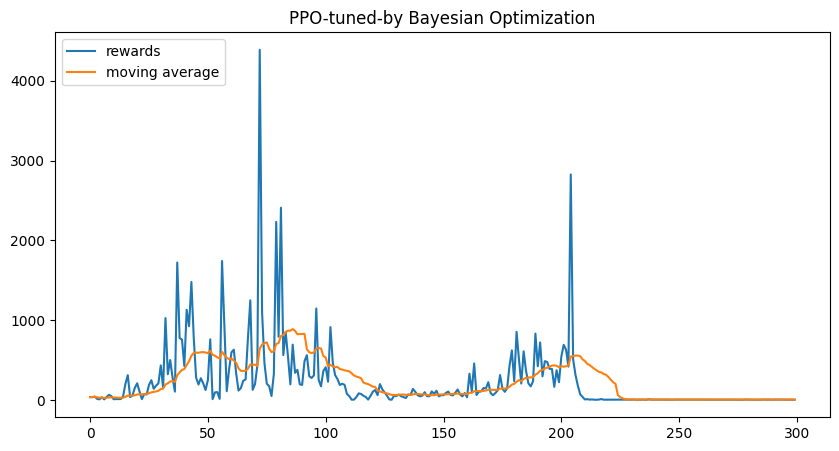

In [128]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label = "rewards")
plt.plot(agent.moving_avg_list, label = "moving average")
plt.legend(loc = "upper left")
plt.title("PPO-tuned-by Bayesian Optimization")
plt.show()